In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('heart_cleaned.csv')
df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289.0,0,172,0,0.0,False,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,0,160,180.0,0,156,0,1.0,True,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,1,130,283.0,0,98,0,0.0,False,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,48,0,138,214.0,0,108,1,1.5,True,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,54,1,150,195.0,0,122,0,0.0,False,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [4]:
class FeatureCategorizer:
    def __init__(self, df):
        self.df = df.copy()
        self.continuous_features = []
        self.binary_features = []
        
    def categorize_features(self):
        
        for col in self.df.columns:
            unique_vals = self.df[col].nunique()
            is_numeric = pd.api.types.is_numeric_dtype(self.df[col])
            unique_values = sorted(self.df[col].unique())

            if is_numeric:
                if unique_vals == 2 or set(self.df[col].unique()).issubset({0, 1, 0.0, 1.0}):
                    self.binary_features.append(col)
                else:
                    self.continuous_features.append(col)
            else:
                # Handle boolean or string binary features
                if unique_vals == 2:
                    self.binary_features.append(col)
                else:
                    print(f"  → Classified as: OTHER (will be ignored)")
        return self.continuous_features, self.binary_features
# Categorize features
categorizer = FeatureCategorizer(df)
continuous_features, binary_features = categorizer.categorize_features()


In [5]:
from sklearn.feature_selection import mutual_info_classif

X = df.drop('HeartDisease', axis=1)
Y = df['HeartDisease']

mutua_informazione_feature = []

def analyze_feature_information(X, Y, continuous_features, binary_features):
    """
    Calcola la mutual information media per feature numeriche e binarie.
    
    Args:
        X (pd.DataFrame): dataset delle feature
        y (pd.Series o array): target
        numerical_features (list): lista nomi delle feature numeriche
        binary_features (list): lista nomi delle feature binarie
    
    Returns:
        dict: valori medi di mutual information
    """
    # Calcolo mutual information per tutte le feature
    mi = mutual_info_classif(X, Y, discrete_features='auto', random_state=42)
    mi_df = pd.DataFrame({
        "feature": X.columns,
        "mutual_info": mi
    })
    
    # Separazione numeriche e binarie
    mi_numerical = mi_df[mi_df["feature"].isin(continuous_features)]["mutual_info"].mean()
    mi_binary = mi_df[mi_df["feature"].isin(binary_features)]["mutual_info"].mean()
    
    return {
        "MI_numerical": mi_numerical,
        "MI_binary": mi_binary
    }

ris = analyze_feature_information(X, Y, continuous_features, binary_features)
print(ris)

{'MI_numerical': np.float64(0.06646737346489448), 'MI_binary': np.float64(0.06725815612608918)}


In [6]:
def progressive_duplicate(df, steps=10, random_state=None):
    """
    Duplica progressivamente una percentuale crescente di righe del DataFrame.
    Restituisce una lista di DataFrame con duplicazioni crescenti.
    """
    np.random.seed(random_state)
    dfs = []
    n_rows = df.shape[0]
    for i in range(1, steps + 1):
        perc = i / steps
        n_dup = int(n_rows * perc)
        idx_to_duplicate = np.random.choice(df.index, n_dup, replace=False)
        df_dup = pd.concat([df, df.loc[idx_to_duplicate]], ignore_index=True)
        dfs.append(df_dup)
    return dfs

duplicated_dfs = progressive_duplicate(df, steps=10, random_state=42)

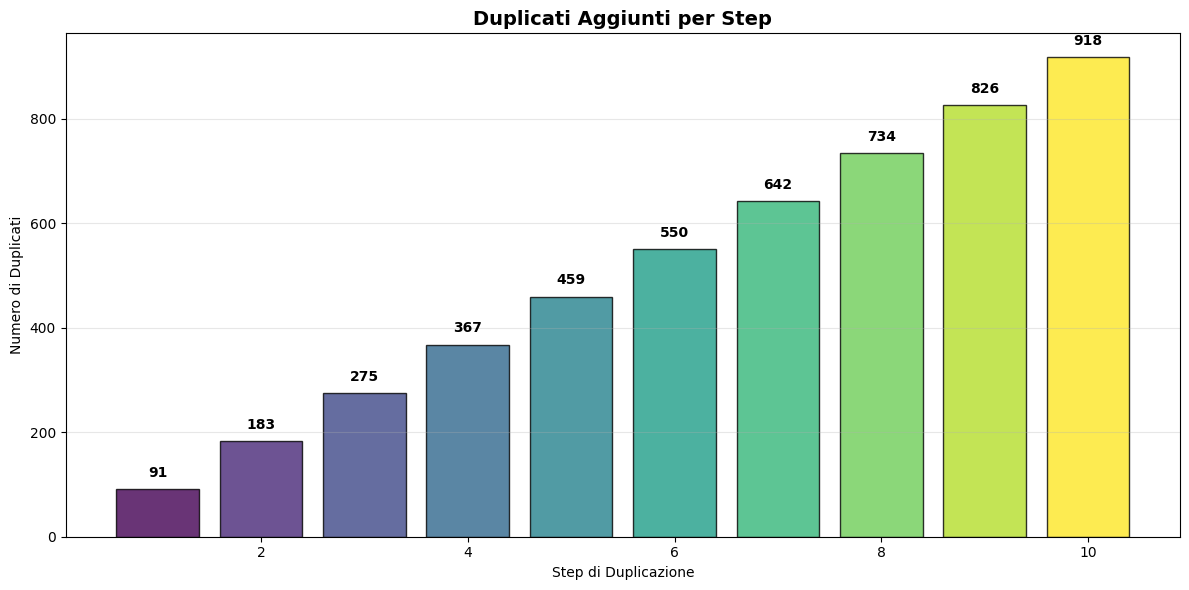

In [7]:
# Funzione visualizzazione righe duplicate
def simple_duplication_plot(df, duplicated_dfs, steps=10):
    """
    Crea un grafico semplice per visualizzare la crescita del dataset
    """
    original_size = len(df)
    step_numbers = list(range(1, steps + 1))
    dataset_sizes = [len(df_dup) for df_dup in duplicated_dfs]
    
    # Subplot 1: Duplicati aggiunti
    plt.figure(figsize=(12, 6))
    duplicate_counts = [size - original_size for size in dataset_sizes]
    colors = plt.cm.viridis(np.linspace(0, 1, len(duplicate_counts)))
    bars = plt.bar(step_numbers, duplicate_counts, color=colors, edgecolor='black', alpha=0.8)
    
    # Aggiungi etichette
    for bar, count in zip(bars, duplicate_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(duplicate_counts)*0.02, 
                str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.title('Duplicati Aggiunti per Step', fontsize=14, fontweight='bold')
    plt.xlabel('Step di Duplicazione')
    plt.ylabel('Numero di Duplicati')
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

# Esempio d'uso per il grafico semplice:
simple_duplication_plot(df, duplicated_dfs, steps=10)

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

all_metrics_duplicates = []

def calculate_metrics(y_test, y_pred, model_name, approach, step_idx):
    """
    Calculate metrics and return a dictionary with model info
    """
    metrics = {
        'model': model_name,
        'approach': approach,
        'step': step_idx,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }
    
    # Print metrics (to maintain your current output format)
    print(f"Misure di performance globali {model_name.lower()} {approach.lower()}\n")
    print('Accuracy:', metrics['accuracy'])
    print('Precision:', metrics['precision'])
    print('Recall:', metrics['recall'])
    print('F1-score:', metrics['f1_score'])
    
    return metrics

timing_collector_duplicates = {
    'dt_naive_training': 0,
    'dt_optimal_training': 0, 
    'dt_hyperparameter': 0,
    'svm_naive_training': 0,
    'svm_optimal_training': 0,
    'svm_hyperparameter': 0,
    'nn_naive_training': 0,
    'nn_optimal_training': 0,
    'nn_hyperparameter': 0
}


===== Training Decision Tree (Naive) at Step 0 =====
Misure di performance globali decision tree naive

Accuracy: 0.9130434782608695
Precision: 0.9174311926605505
Recall: 0.9345794392523364
F1-score: 0.9259259259259259
Step 0 - Decision Tree (Naive)
  Accuracy Test:   0.9130
  Accuracy Train:  1.0000
  Precision:       0.9174
  Recall:          0.9346
  F1-score:        0.9259
  Training time:   0.0024 sec


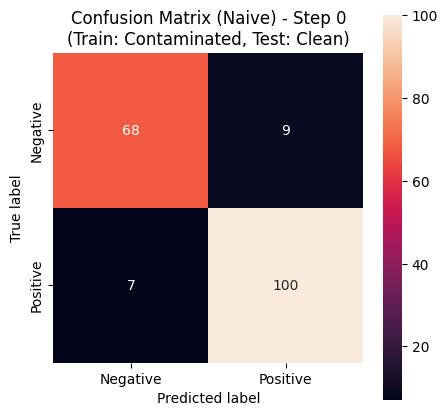

Feature Importances: [0.037708   0.03914872 0.09591823 0.05309678 0.01217774 0.11325652
 0.00583044 0.08452602 0.10852467 0.00794508 0.00374814 0.
 0.00949464 0.01328812 0.00608512 0.00649678 0.01290396 0.38985104]
✅ Step 0 completed


===== Training Decision Tree (Naive) at Step 1 =====
Misure di performance globali decision tree naive

Accuracy: 0.9130434782608695
Precision: 0.9595959595959596
Recall: 0.8878504672897196
F1-score: 0.9223300970873787
Step 1 - Decision Tree (Naive)
  Accuracy Test:   0.9130
  Accuracy Train:  1.0000
  Precision:       0.9596
  Recall:          0.8879
  F1-score:        0.9223
  Training time:   0.0025 sec


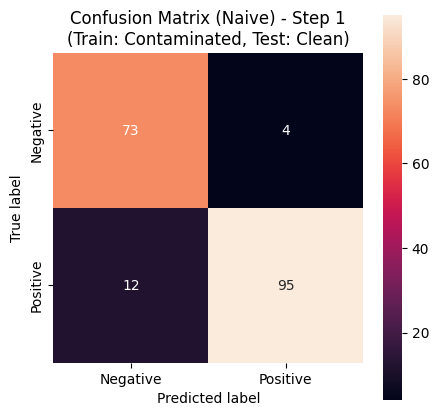

Feature Importances: [0.05671814 0.02846265 0.08627948 0.07028266 0.01327443 0.12714138
 0.00437194 0.07135369 0.0755301  0.00513098 0.00897149 0.00356053
 0.00780138 0.         0.00535017 0.00305188 0.00826457 0.42445455]
✅ Step 1 completed


===== Training Decision Tree (Naive) at Step 2 =====
Misure di performance globali decision tree naive

Accuracy: 0.9456521739130435
Precision: 0.970873786407767
Recall: 0.9345794392523364
F1-score: 0.9523809523809523
Step 2 - Decision Tree (Naive)
  Accuracy Test:   0.9457
  Accuracy Train:  1.0000
  Precision:       0.9709
  Recall:          0.9346
  F1-score:        0.9524
  Training time:   0.0026 sec


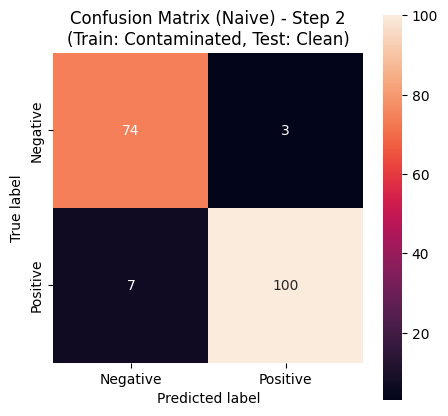

Feature Importances: [0.06417989 0.03568934 0.06802068 0.10028217 0.00787668 0.1328005
 0.01158178 0.07475201 0.07292895 0.00682498 0.         0.
 0.00594835 0.0046608  0.01041759 0.00421965 0.         0.39981665]
✅ Step 2 completed


===== Training Decision Tree (Naive) at Step 3 =====
Misure di performance globali decision tree naive

Accuracy: 0.9728260869565217
Precision: 1.0
Recall: 0.9532710280373832
F1-score: 0.9760765550239234
Step 3 - Decision Tree (Naive)
  Accuracy Test:   0.9728
  Accuracy Train:  1.0000
  Precision:       1.0000
  Recall:          0.9533
  F1-score:        0.9761
  Training time:   0.0036 sec


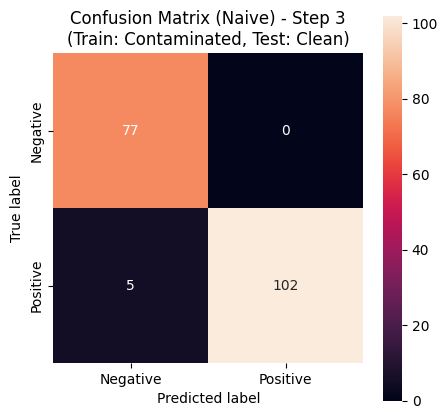

Feature Importances: [0.06366371 0.03737655 0.09245206 0.0852683  0.01410589 0.10493969
 0.01646544 0.10335993 0.10244596 0.         0.0073905  0.
 0.00261983 0.01135258 0.00710479 0.         0.00576916 0.34568562]
✅ Step 3 completed


===== Training Decision Tree (Naive) at Step 4 =====
Misure di performance globali decision tree naive

Accuracy: 0.9891304347826086
Precision: 0.981651376146789
Recall: 1.0
F1-score: 0.9907407407407407
Step 4 - Decision Tree (Naive)
  Accuracy Test:   0.9891
  Accuracy Train:  1.0000
  Precision:       0.9817
  Recall:          1.0000
  F1-score:        0.9907
  Training time:   0.0029 sec


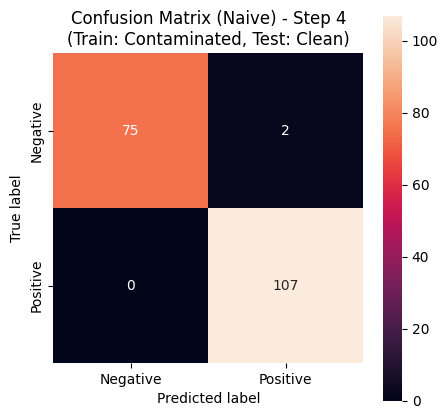

Feature Importances: [0.06891875 0.02844377 0.09077826 0.06568832 0.         0.12094671
 0.01193858 0.08553273 0.11090004 0.00529984 0.00872095 0.0086597
 0.00459861 0.01139112 0.00429745 0.         0.00489941 0.36898575]
✅ Step 4 completed


===== Training Decision Tree (Naive) at Step 5 =====
Misure di performance globali decision tree naive

Accuracy: 0.9891304347826086
Precision: 0.981651376146789
Recall: 1.0
F1-score: 0.9907407407407407
Step 5 - Decision Tree (Naive)
  Accuracy Test:   0.9891
  Accuracy Train:  1.0000
  Precision:       0.9817
  Recall:          1.0000
  F1-score:        0.9907
  Training time:   0.0030 sec


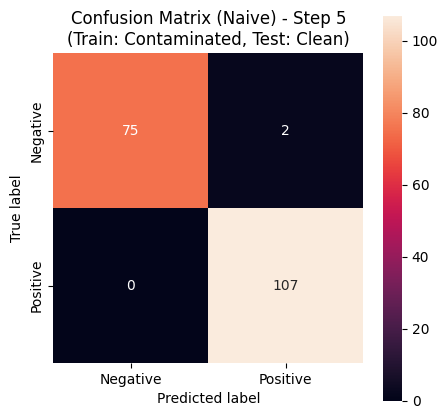

Feature Importances: [0.0518812  0.02954656 0.10813411 0.04898721 0.008875   0.13565881
 0.01018185 0.09295902 0.08111844 0.         0.00619386 0.00229462
 0.0049809  0.00116003 0.02317031 0.         0.01008044 0.38477765]
✅ Step 5 completed


===== Training Decision Tree (Naive) at Step 6 =====
Misure di performance globali decision tree naive

Accuracy: 0.9891304347826086
Precision: 0.981651376146789
Recall: 1.0
F1-score: 0.9907407407407407
Step 6 - Decision Tree (Naive)
  Accuracy Test:   0.9891
  Accuracy Train:  1.0000
  Precision:       0.9817
  Recall:          1.0000
  F1-score:        0.9907
  Training time:   0.0032 sec


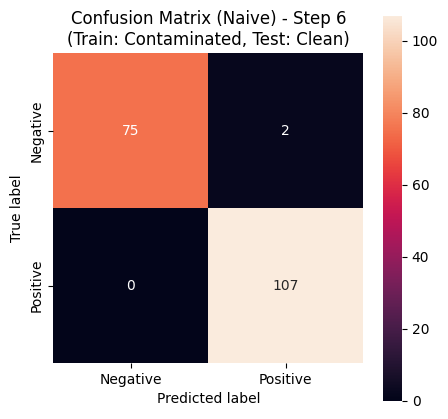

Feature Importances: [0.06709362 0.04160722 0.07042125 0.06550933 0.01964895 0.09614776
 0.01044297 0.08210709 0.10153233 0.0010764  0.0036504  0.002704
 0.00547561 0.00500241 0.00544121 0.00804646 0.00389376 0.41019923]
✅ Step 6 completed


===== Training Decision Tree (Naive) at Step 7 =====
Misure di performance globali decision tree naive

Accuracy: 0.9782608695652174
Precision: 0.9724770642201835
Recall: 0.9906542056074766
F1-score: 0.9814814814814815
Step 7 - Decision Tree (Naive)
  Accuracy Test:   0.9783
  Accuracy Train:  1.0000
  Precision:       0.9725
  Recall:          0.9907
  F1-score:        0.9815
  Training time:   0.0033 sec


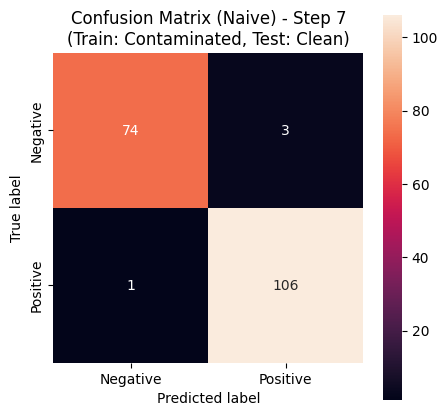

Feature Importances: [0.05652225 0.02201223 0.06295492 0.10530161 0.01284214 0.09533628
 0.00320134 0.1043168  0.09891229 0.00452252 0.         0.00527602
 0.02066593 0.0111043  0.00388216 0.00663223 0.00368043 0.38283656]
✅ Step 7 completed


===== Training Decision Tree (Naive) at Step 8 =====
Misure di performance globali decision tree naive

Accuracy: 0.9891304347826086
Precision: 0.9906542056074766
Recall: 0.9906542056074766
F1-score: 0.9906542056074766
Step 8 - Decision Tree (Naive)
  Accuracy Test:   0.9891
  Accuracy Train:  1.0000
  Precision:       0.9907
  Recall:          0.9907
  F1-score:        0.9907
  Training time:   0.0048 sec


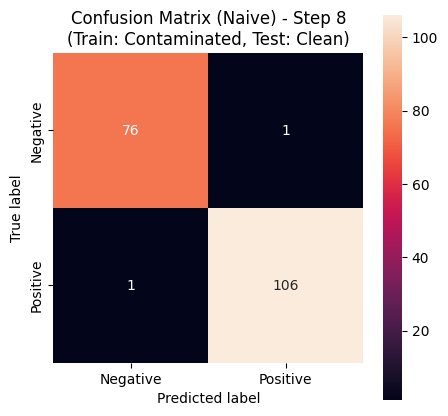

Feature Importances: [0.06715316 0.03352847 0.07303255 0.09067987 0.0218202  0.09946783
 0.00193021 0.09395298 0.10282545 0.00217148 0.         0.006586
 0.01292082 0.00434296 0.007385   0.         0.00347437 0.37872865]
✅ Step 8 completed


===== Training Decision Tree (Naive) at Step 9 =====
Misure di performance globali decision tree naive

Accuracy: 0.9891304347826086
Precision: 0.9906542056074766
Recall: 0.9906542056074766
F1-score: 0.9906542056074766
Step 9 - Decision Tree (Naive)
  Accuracy Test:   0.9891
  Accuracy Train:  1.0000
  Precision:       0.9907
  Recall:          0.9907
  F1-score:        0.9907
  Training time:   0.0043 sec


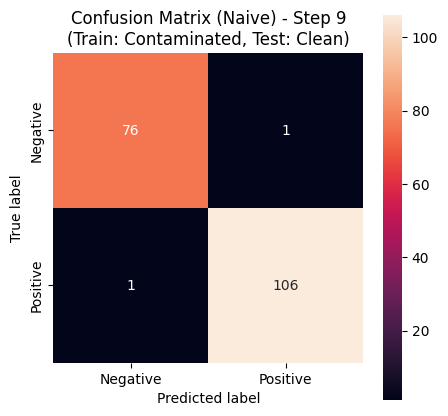

Feature Importances: [0.07551878 0.0216906  0.06148303 0.06313196 0.01736725 0.13320219
 0.01891419 0.09807528 0.07732841 0.         0.00468657 0.00667239
 0.00838955 0.00455532 0.0076181  0.         0.01323379 0.3881326 ]
✅ Step 9 completed



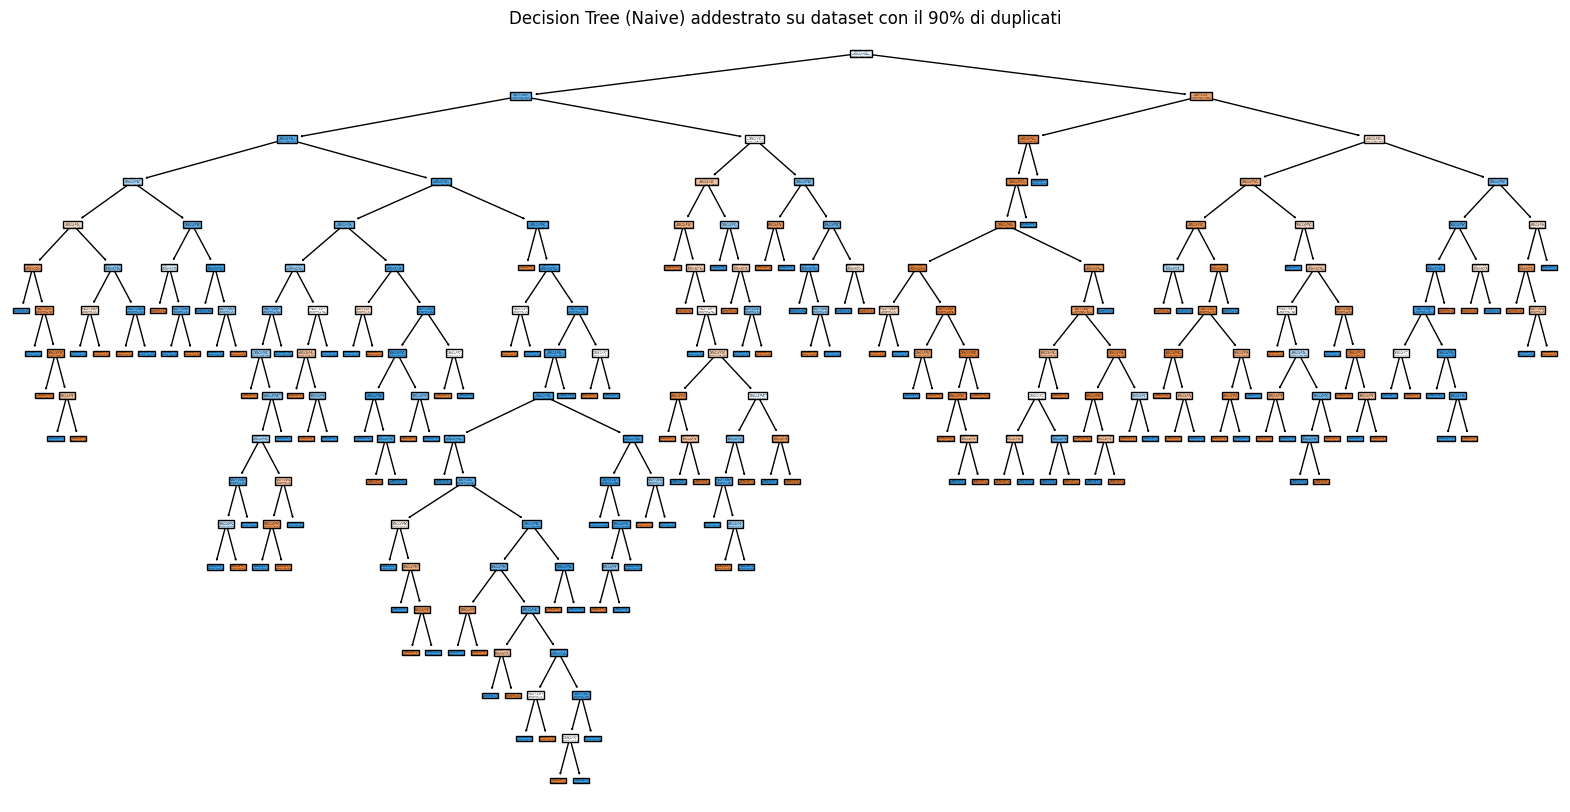


===== Training Decision Tree (Optimized) at Step 0 =====
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036
Step 0 - Decision Tree (Optimized)
  Accuracy Test:   0.7989
  Accuracy Train:  0.8600
  Precision:       0.8182
  Recall:          0.8411
  F1-score:        0.8295
  Training time:   0.0010 sec


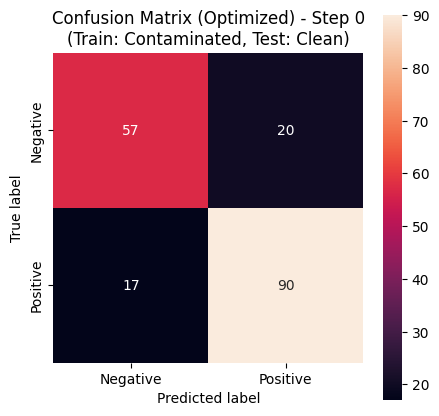

Feature Importances: [0.         0.06361518 0.         0.         0.         0.
 0.03926343 0.01567565 0.19194075 0.         0.         0.
 0.         0.         0.         0.         0.         0.68950499]
✅ Step 0 completed


===== Training Decision Tree (Optimized) at Step 1 =====
Misure di performance globali decision tree optimized

Accuracy: 0.8206521739130435
Precision: 0.8557692307692307
Recall: 0.8317757009345794
F1-score: 0.8436018957345972
Step 1 - Decision Tree (Optimized)
  Accuracy Test:   0.8207
  Accuracy Train:  0.8580
  Precision:       0.8558
  Recall:          0.8318
  F1-score:        0.8436
  Training time:   0.0010 sec


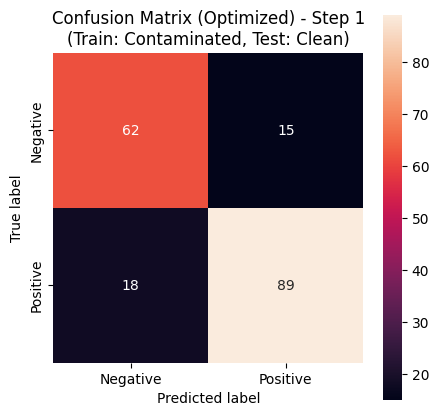

Feature Importances: [0.         0.06424533 0.         0.         0.02761624 0.
 0.03290473 0.0213919  0.12438811 0.         0.         0.
 0.         0.         0.         0.         0.         0.72945368]
✅ Step 1 completed


===== Training Decision Tree (Optimized) at Step 2 =====
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036
Step 2 - Decision Tree (Optimized)
  Accuracy Test:   0.7989
  Accuracy Train:  0.8627
  Precision:       0.8182
  Recall:          0.8411
  F1-score:        0.8295
  Training time:   0.0015 sec


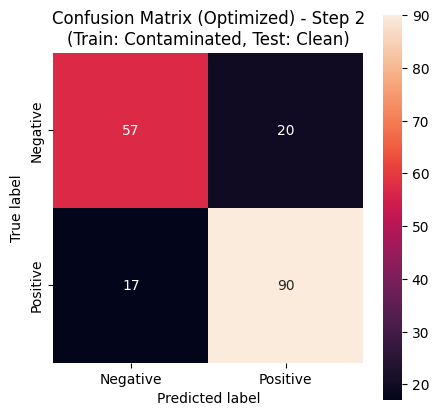

Feature Importances: [0.         0.07677983 0.         0.         0.         0.
 0.05047903 0.00722676 0.1642558  0.         0.         0.
 0.         0.         0.         0.         0.         0.70125858]
✅ Step 2 completed


===== Training Decision Tree (Optimized) at Step 3 =====
Misure di performance globali decision tree optimized

Accuracy: 0.8152173913043478
Precision: 0.811965811965812
Recall: 0.8878504672897196
F1-score: 0.8482142857142857
Step 3 - Decision Tree (Optimized)
  Accuracy Test:   0.8152
  Accuracy Train:  0.8395
  Precision:       0.8120
  Recall:          0.8879
  F1-score:        0.8482
  Training time:   0.0013 sec


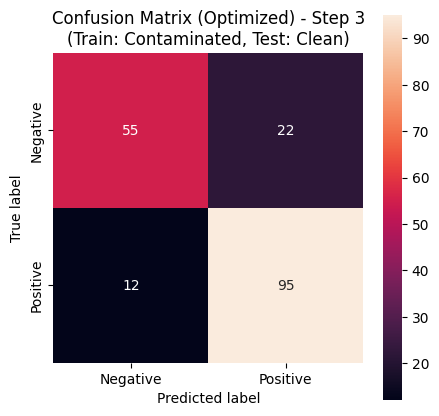

Feature Importances: [0.         0.06043032 0.         0.         0.00552433 0.
 0.         0.05614992 0.20069293 0.         0.         0.
 0.         0.         0.         0.         0.         0.6772025 ]
✅ Step 3 completed


===== Training Decision Tree (Optimized) at Step 4 =====
Misure di performance globali decision tree optimized

Accuracy: 0.7934782608695652
Precision: 0.8165137614678899
Recall: 0.8317757009345794
F1-score: 0.8240740740740741
Step 4 - Decision Tree (Optimized)
  Accuracy Test:   0.7935
  Accuracy Train:  0.8465
  Precision:       0.8165
  Recall:          0.8318
  F1-score:        0.8241
  Training time:   0.0023 sec


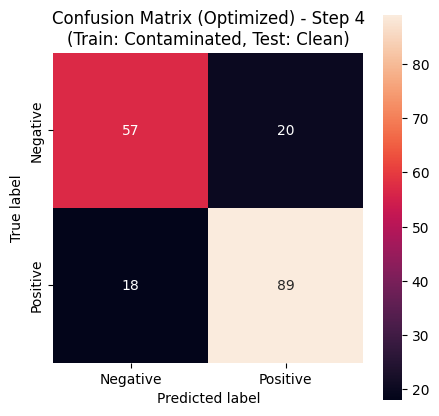

Feature Importances: [0.         0.05642446 0.         0.         0.03588199 0.
 0.         0.00571708 0.20844381 0.         0.         0.
 0.         0.         0.         0.         0.         0.69353266]
✅ Step 4 completed


===== Training Decision Tree (Optimized) at Step 5 =====
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036
Step 5 - Decision Tree (Optimized)
  Accuracy Test:   0.7989
  Accuracy Train:  0.8552
  Precision:       0.8182
  Recall:          0.8411
  F1-score:        0.8295
  Training time:   0.0011 sec


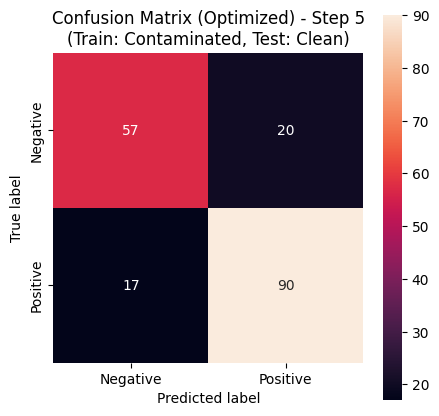

Feature Importances: [0.         0.08397339 0.         0.         0.         0.
 0.03586458 0.01093504 0.16906988 0.         0.         0.
 0.         0.         0.         0.         0.         0.70015711]
✅ Step 5 completed


===== Training Decision Tree (Optimized) at Step 6 =====
Misure di performance globali decision tree optimized

Accuracy: 0.8206521739130435
Precision: 0.8245614035087719
Recall: 0.8785046728971962
F1-score: 0.8506787330316742
Step 6 - Decision Tree (Optimized)
  Accuracy Test:   0.8207
  Accuracy Train:  0.8742
  Precision:       0.8246
  Recall:          0.8785
  F1-score:        0.8507
  Training time:   0.0010 sec


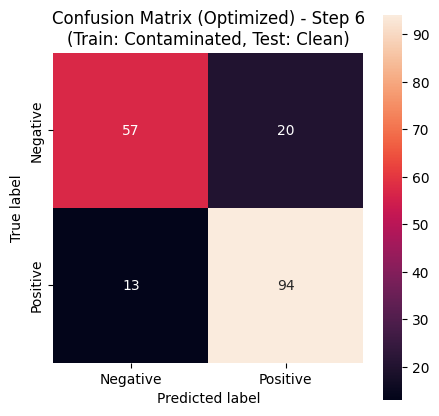

Feature Importances: [0.         0.05893183 0.         0.         0.         0.
 0.         0.07680479 0.17147794 0.         0.         0.
 0.         0.         0.         0.         0.         0.69278544]
✅ Step 6 completed


===== Training Decision Tree (Optimized) at Step 7 =====
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036
Step 7 - Decision Tree (Optimized)
  Accuracy Test:   0.7989
  Accuracy Train:  0.8463
  Precision:       0.8182
  Recall:          0.8411
  F1-score:        0.8295
  Training time:   0.0011 sec


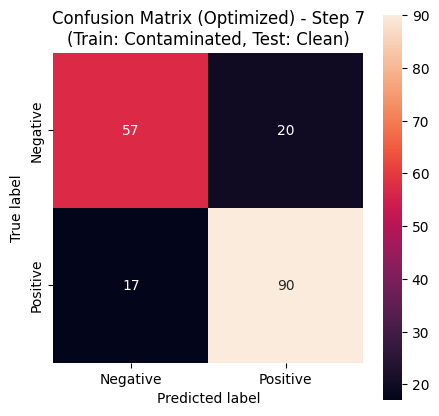

Feature Importances: [0.         0.04807462 0.         0.         0.         0.
 0.03527957 0.00749612 0.18666589 0.         0.         0.
 0.         0.         0.         0.         0.         0.7224838 ]
✅ Step 7 completed


===== Training Decision Tree (Optimized) at Step 8 =====
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036
Step 8 - Decision Tree (Optimized)
  Accuracy Test:   0.7989
  Accuracy Train:  0.8466
  Precision:       0.8182
  Recall:          0.8411
  F1-score:        0.8295
  Training time:   0.0013 sec


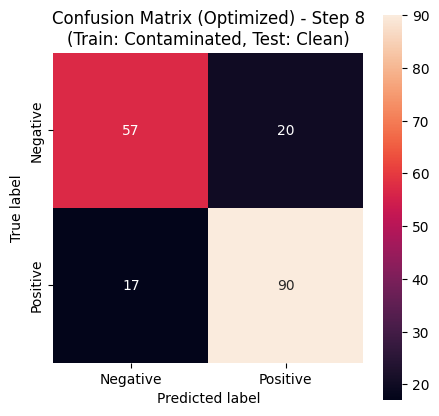

Feature Importances: [0.         0.05287832 0.         0.         0.00626467 0.
 0.03607074 0.         0.19319752 0.         0.         0.
 0.         0.         0.         0.         0.         0.71158875]
✅ Step 8 completed


===== Training Decision Tree (Optimized) at Step 9 =====
Misure di performance globali decision tree optimized

Accuracy: 0.8206521739130435
Precision: 0.8627450980392157
Recall: 0.822429906542056
F1-score: 0.8421052631578947
Step 9 - Decision Tree (Optimized)
  Accuracy Test:   0.8207
  Accuracy Train:  0.8508
  Precision:       0.8627
  Recall:          0.8224
  F1-score:        0.8421
  Training time:   0.0010 sec


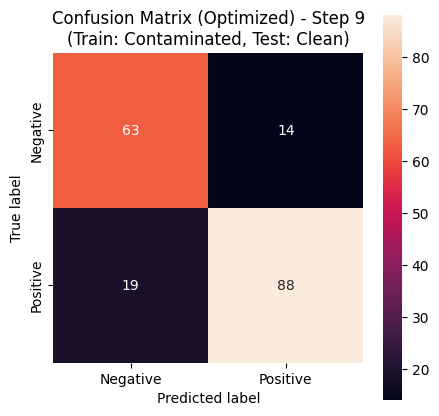

Feature Importances: [0.         0.01507213 0.         0.         0.00569762 0.05198595
 0.         0.04699697 0.17076736 0.         0.         0.
 0.         0.         0.         0.         0.         0.70947997]
✅ Step 9 completed



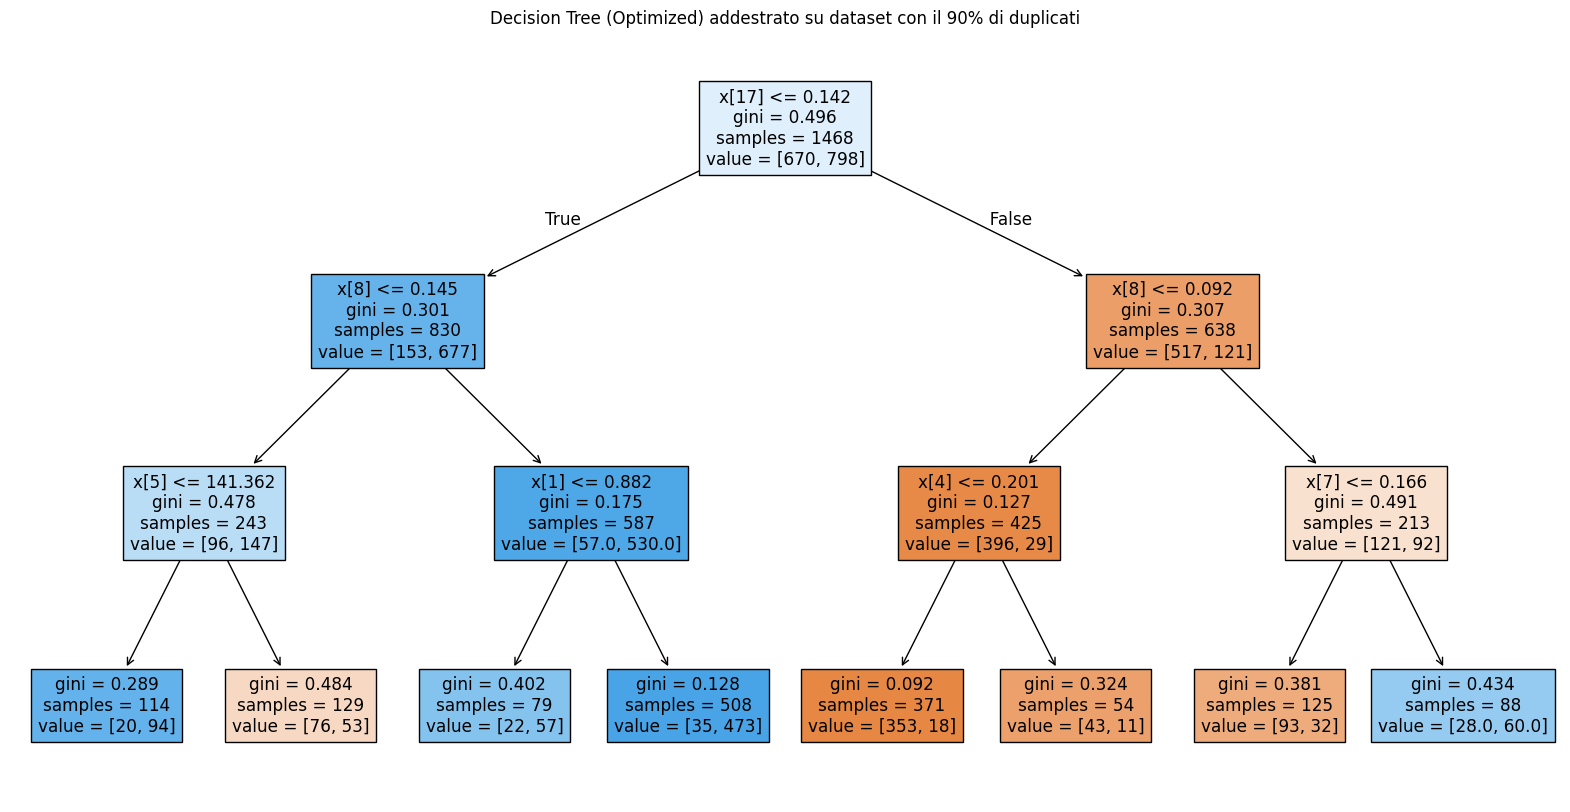


===== Training SVM (Naive) at Step 0 =====
Misure di performance globali svm naive

Accuracy: 0.6793478260869565
Precision: 0.7181818181818181
Recall: 0.7383177570093458
F1-score: 0.728110599078341
Step 0 - SVM (Naive)
  Accuracy Test:   0.6793
  Accuracy Train:  0.7026
  Precision:       0.7182
  Recall:          0.7383
  F1-score:        0.7281
  Training time:   0.0105 sec


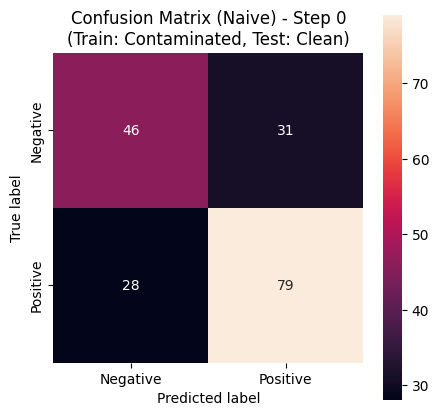

✅ Step 0 completed


===== Training SVM (Naive) at Step 1 =====
Misure di performance globali svm naive

Accuracy: 0.6956521739130435
Precision: 0.7428571428571429
Recall: 0.7289719626168224
F1-score: 0.7358490566037735
Step 1 - SVM (Naive)
  Accuracy Test:   0.6957
  Accuracy Train:  0.7000
  Precision:       0.7429
  Recall:          0.7290
  F1-score:        0.7358
  Training time:   0.0120 sec


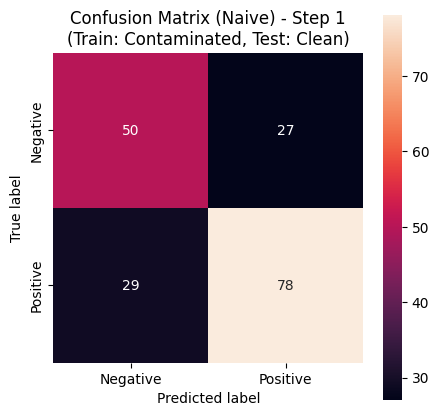

✅ Step 1 completed


===== Training SVM (Naive) at Step 2 =====
Misure di performance globali svm naive

Accuracy: 0.6793478260869565
Precision: 0.7222222222222222
Recall: 0.7289719626168224
F1-score: 0.7255813953488373
Step 2 - SVM (Naive)
  Accuracy Test:   0.6793
  Accuracy Train:  0.7233
  Precision:       0.7222
  Recall:          0.7290
  F1-score:        0.7256
  Training time:   0.0249 sec


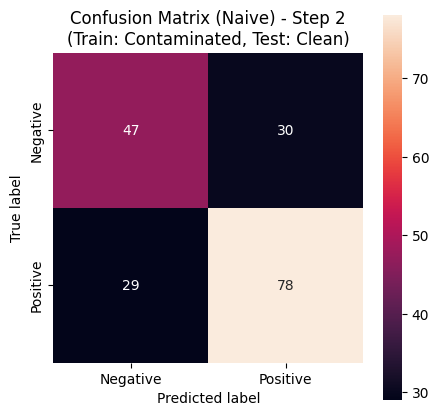

✅ Step 2 completed


===== Training SVM (Naive) at Step 3 =====
Misure di performance globali svm naive

Accuracy: 0.6847826086956522
Precision: 0.7207207207207207
Recall: 0.7476635514018691
F1-score: 0.7339449541284404
Step 3 - SVM (Naive)
  Accuracy Test:   0.6848
  Accuracy Train:  0.6975
  Precision:       0.7207
  Recall:          0.7477
  F1-score:        0.7339
  Training time:   0.0149 sec


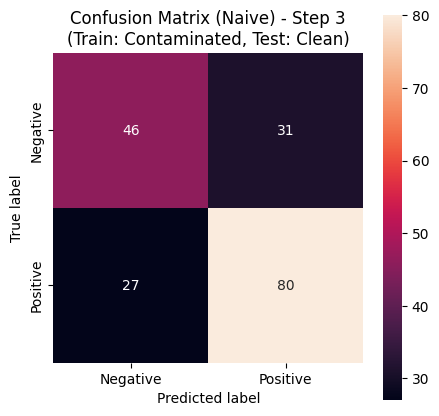

✅ Step 3 completed


===== Training SVM (Naive) at Step 4 =====
Misure di performance globali svm naive

Accuracy: 0.6847826086956522
Precision: 0.7168141592920354
Recall: 0.7570093457943925
F1-score: 0.7363636363636363
Step 4 - SVM (Naive)
  Accuracy Test:   0.6848
  Accuracy Train:  0.7103
  Precision:       0.7168
  Recall:          0.7570
  F1-score:        0.7364
  Training time:   0.0170 sec


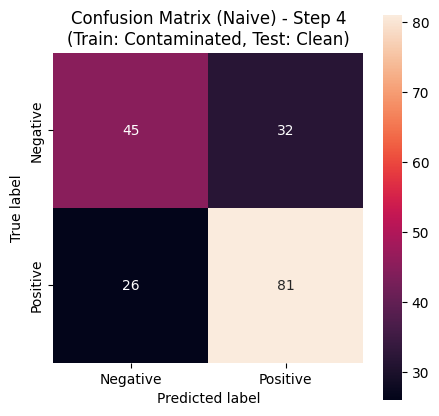

✅ Step 4 completed


===== Training SVM (Naive) at Step 5 =====
Misure di performance globali svm naive

Accuracy: 0.6902173913043478
Precision: 0.7232142857142857
Recall: 0.7570093457943925
F1-score: 0.7397260273972602
Step 5 - SVM (Naive)
  Accuracy Test:   0.6902
  Accuracy Train:  0.7104
  Precision:       0.7232
  Recall:          0.7570
  F1-score:        0.7397
  Training time:   0.0228 sec


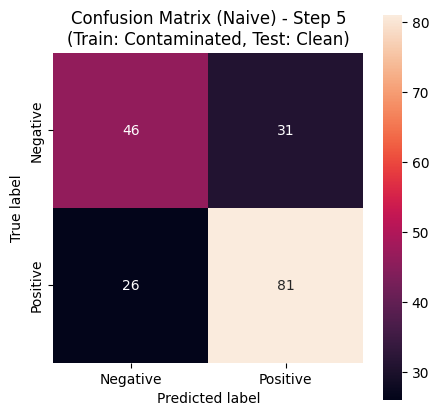

✅ Step 5 completed


===== Training SVM (Naive) at Step 6 =====
Misure di performance globali svm naive

Accuracy: 0.6956521739130435
Precision: 0.7297297297297297
Recall: 0.7570093457943925
F1-score: 0.7431192660550459
Step 6 - SVM (Naive)
  Accuracy Test:   0.6957
  Accuracy Train:  0.6899
  Precision:       0.7297
  Recall:          0.7570
  F1-score:        0.7431
  Training time:   0.0212 sec


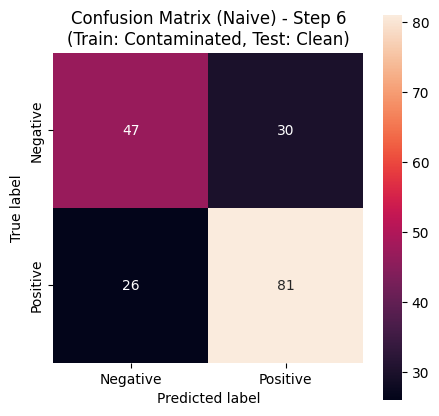

✅ Step 6 completed


===== Training SVM (Naive) at Step 7 =====
Misure di performance globali svm naive

Accuracy: 0.6847826086956522
Precision: 0.7207207207207207
Recall: 0.7476635514018691
F1-score: 0.7339449541284404
Step 7 - SVM (Naive)
  Accuracy Test:   0.6848
  Accuracy Train:  0.7070
  Precision:       0.7207
  Recall:          0.7477
  F1-score:        0.7339
  Training time:   0.0267 sec


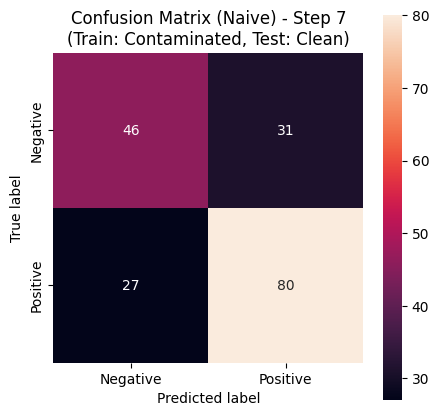

✅ Step 7 completed


===== Training SVM (Naive) at Step 8 =====
Misure di performance globali svm naive

Accuracy: 0.6902173913043478
Precision: 0.7272727272727273
Recall: 0.7476635514018691
F1-score: 0.7373271889400922
Step 8 - SVM (Naive)
  Accuracy Test:   0.6902
  Accuracy Train:  0.7032
  Precision:       0.7273
  Recall:          0.7477
  F1-score:        0.7373
  Training time:   0.0260 sec


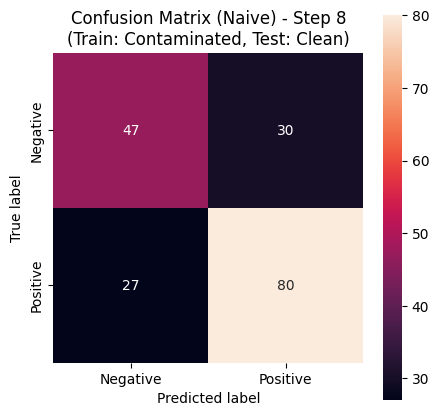

✅ Step 8 completed


===== Training SVM (Naive) at Step 9 =====
Misure di performance globali svm naive

Accuracy: 0.6739130434782609
Precision: 0.7326732673267327
Recall: 0.6915887850467289
F1-score: 0.7115384615384616
Step 9 - SVM (Naive)
  Accuracy Test:   0.6739
  Accuracy Train:  0.7023
  Precision:       0.7327
  Recall:          0.6916
  F1-score:        0.7115
  Training time:   0.0314 sec


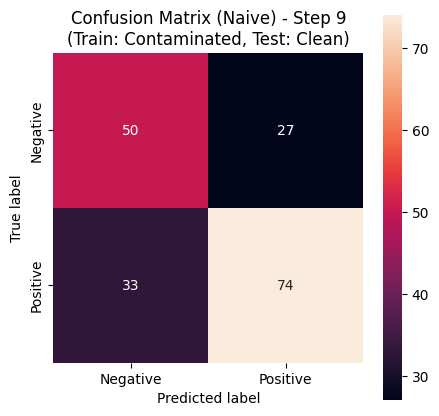

✅ Step 9 completed


===== Training SVM (Optimized) at Step 0 =====
Misure di performance globali svm optimized

Accuracy: 0.8586956521739131
Precision: 0.8584070796460177
Recall: 0.9065420560747663
F1-score: 0.8818181818181818
Step 0 - SVM (Optimized)
  Accuracy Test:   0.8587
  Accuracy Train:  1.0000
  Precision:       0.8584
  Recall:          0.9065
  F1-score:        0.8818
  Training time:   0.0163 sec


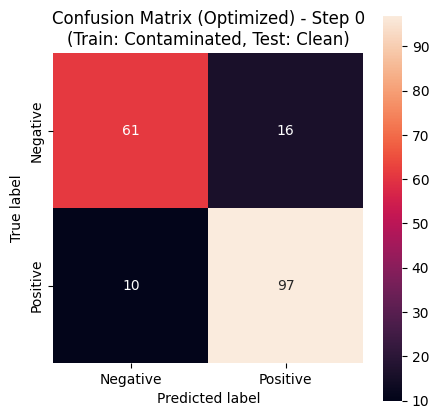

✅ Step 0 completed


===== Training SVM (Optimized) at Step 1 =====
Misure di performance globali svm optimized

Accuracy: 0.9021739130434783
Precision: 0.9238095238095239
Recall: 0.9065420560747663
F1-score: 0.9150943396226415
Step 1 - SVM (Optimized)
  Accuracy Test:   0.9022
  Accuracy Train:  1.0000
  Precision:       0.9238
  Recall:          0.9065
  F1-score:        0.9151
  Training time:   0.0182 sec


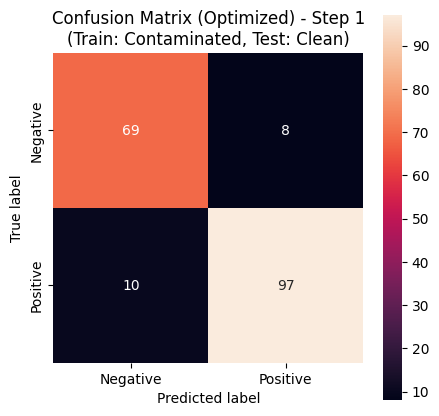

✅ Step 1 completed


===== Training SVM (Optimized) at Step 2 =====
Misure di performance globali svm optimized

Accuracy: 0.9347826086956522
Precision: 0.9439252336448598
Recall: 0.9439252336448598
F1-score: 0.9439252336448598
Step 2 - SVM (Optimized)
  Accuracy Test:   0.9348
  Accuracy Train:  1.0000
  Precision:       0.9439
  Recall:          0.9439
  F1-score:        0.9439
  Training time:   0.0218 sec


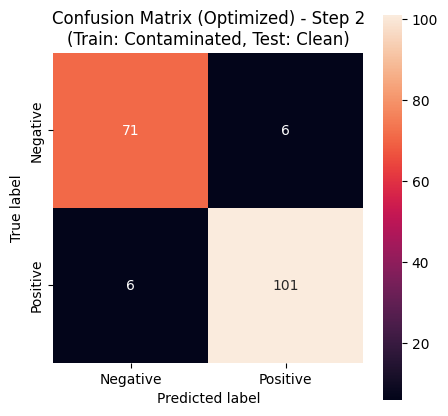

✅ Step 2 completed


===== Training SVM (Optimized) at Step 3 =====
Misure di performance globali svm optimized

Accuracy: 0.9510869565217391
Precision: 0.9537037037037037
Recall: 0.9626168224299065
F1-score: 0.958139534883721
Step 3 - SVM (Optimized)
  Accuracy Test:   0.9511
  Accuracy Train:  1.0000
  Precision:       0.9537
  Recall:          0.9626
  F1-score:        0.9581
  Training time:   0.0189 sec


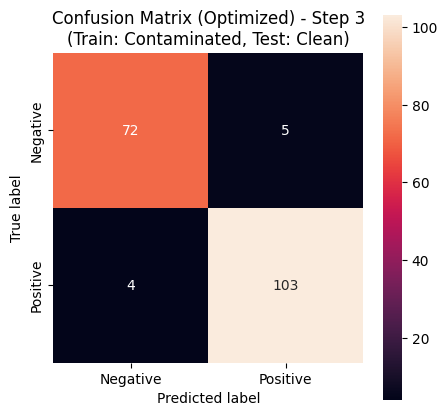

✅ Step 3 completed


===== Training SVM (Optimized) at Step 4 =====
Misure di performance globali svm optimized

Accuracy: 0.9347826086956522
Precision: 0.9130434782608695
Recall: 0.9813084112149533
F1-score: 0.9459459459459459
Step 4 - SVM (Optimized)
  Accuracy Test:   0.9348
  Accuracy Train:  1.0000
  Precision:       0.9130
  Recall:          0.9813
  F1-score:        0.9459
  Training time:   0.0258 sec


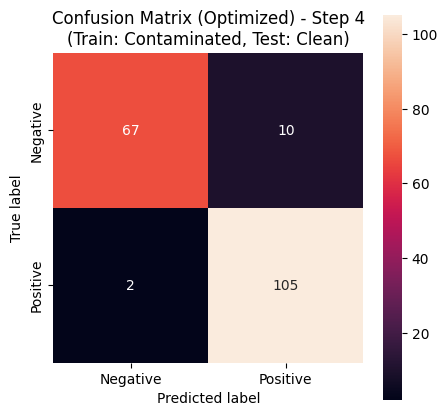

✅ Step 4 completed


===== Training SVM (Optimized) at Step 5 =====
Misure di performance globali svm optimized

Accuracy: 0.9510869565217391
Precision: 0.9298245614035088
Recall: 0.9906542056074766
F1-score: 0.9592760180995475
Step 5 - SVM (Optimized)
  Accuracy Test:   0.9511
  Accuracy Train:  1.0000
  Precision:       0.9298
  Recall:          0.9907
  F1-score:        0.9593
  Training time:   0.0249 sec


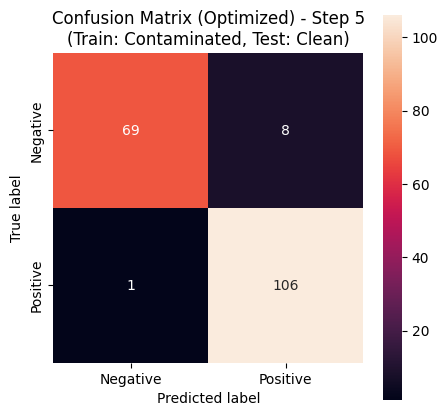

✅ Step 5 completed


===== Training SVM (Optimized) at Step 6 =====
Misure di performance globali svm optimized

Accuracy: 0.967391304347826
Precision: 0.9469026548672567
Recall: 1.0
F1-score: 0.9727272727272728
Step 6 - SVM (Optimized)
  Accuracy Test:   0.9674
  Accuracy Train:  1.0000
  Precision:       0.9469
  Recall:          1.0000
  F1-score:        0.9727
  Training time:   0.0292 sec


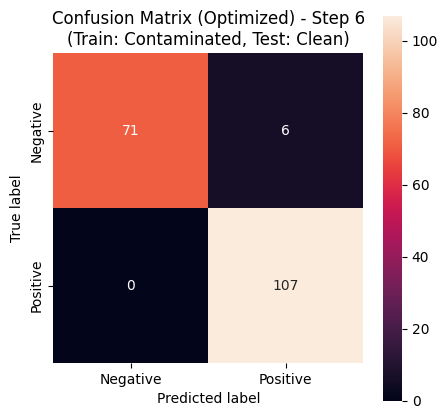

✅ Step 6 completed


===== Training SVM (Optimized) at Step 7 =====
Misure di performance globali svm optimized

Accuracy: 0.967391304347826
Precision: 0.9719626168224299
Recall: 0.9719626168224299
F1-score: 0.9719626168224299
Step 7 - SVM (Optimized)
  Accuracy Test:   0.9674
  Accuracy Train:  1.0000
  Precision:       0.9720
  Recall:          0.9720
  F1-score:        0.9720
  Training time:   0.0330 sec


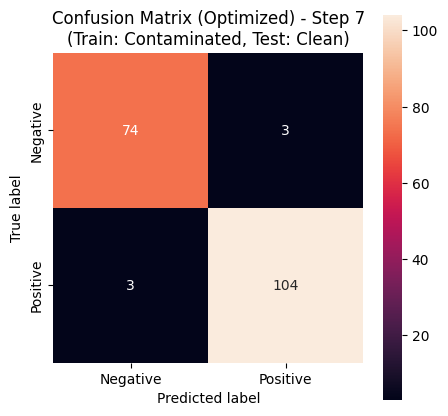

✅ Step 7 completed


===== Training SVM (Optimized) at Step 8 =====
Misure di performance globali svm optimized

Accuracy: 0.967391304347826
Precision: 0.963302752293578
Recall: 0.9813084112149533
F1-score: 0.9722222222222222
Step 8 - SVM (Optimized)
  Accuracy Test:   0.9674
  Accuracy Train:  1.0000
  Precision:       0.9633
  Recall:          0.9813
  F1-score:        0.9722
  Training time:   0.0343 sec


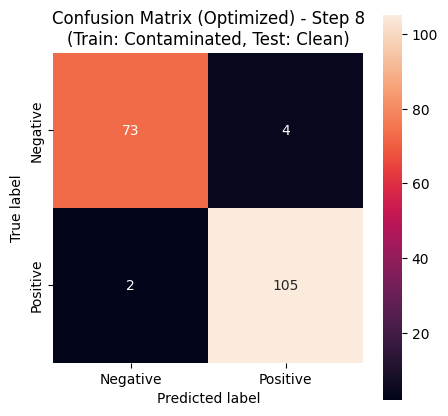

✅ Step 8 completed


===== Training SVM (Optimized) at Step 9 =====
Misure di performance globali svm optimized

Accuracy: 0.967391304347826
Precision: 0.963302752293578
Recall: 0.9813084112149533
F1-score: 0.9722222222222222
Step 9 - SVM (Optimized)
  Accuracy Test:   0.9674
  Accuracy Train:  1.0000
  Precision:       0.9633
  Recall:          0.9813
  F1-score:        0.9722
  Training time:   0.0379 sec


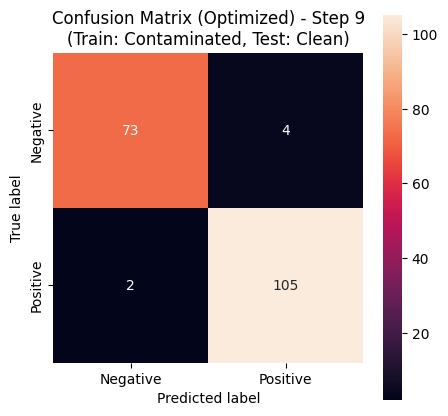

✅ Step 9 completed


===== Training Neural Network (Naive) at Step 0 =====
Misure di performance globali neural network naive

Accuracy: 0.8043478260869565
Precision: 0.865979381443299
Recall: 0.7850467289719626
F1-score: 0.8235294117647058
Step 0 - Neural Network (Naive)
  Accuracy Test:   0.8043
  Accuracy Train:  0.8488
  Precision:       0.8660
  Recall:          0.7850
  F1-score:        0.8235
  Training time:   0.1286 sec


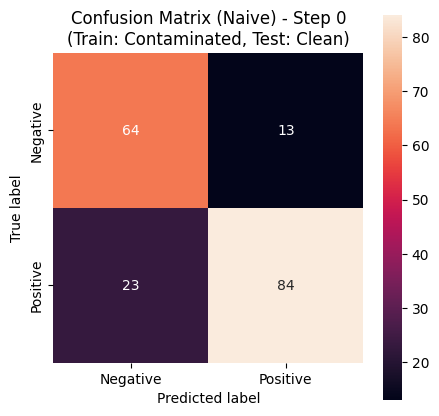

✅ Step 0 completed


===== Training Neural Network (Naive) at Step 1 =====
Misure di performance globali neural network naive

Accuracy: 0.8369565217391305
Precision: 0.8130081300813008
Recall: 0.9345794392523364
F1-score: 0.8695652173913043
Step 1 - Neural Network (Naive)
  Accuracy Test:   0.8370
  Accuracy Train:  0.8636
  Precision:       0.8130
  Recall:          0.9346
  F1-score:        0.8696
  Training time:   0.1239 sec


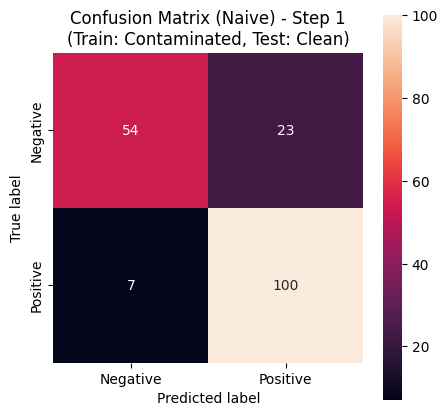

✅ Step 1 completed


===== Training Neural Network (Naive) at Step 2 =====
Misure di performance globali neural network naive

Accuracy: 0.842391304347826
Precision: 0.8305084745762712
Recall: 0.9158878504672897
F1-score: 0.8711111111111111
Step 2 - Neural Network (Naive)
  Accuracy Test:   0.8424
  Accuracy Train:  0.8658
  Precision:       0.8305
  Recall:          0.9159
  F1-score:        0.8711
  Training time:   0.1739 sec


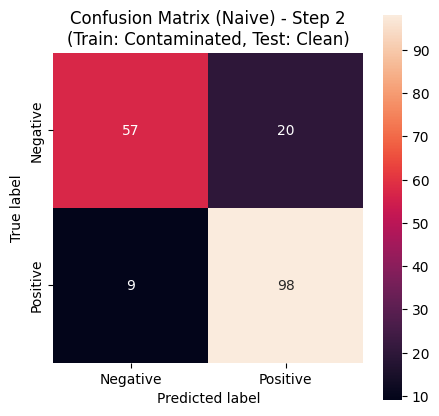

✅ Step 2 completed


===== Training Neural Network (Naive) at Step 3 =====
Misure di performance globali neural network naive

Accuracy: 0.842391304347826
Precision: 0.875
Recall: 0.8504672897196262
F1-score: 0.8625592417061612
Step 3 - Neural Network (Naive)
  Accuracy Test:   0.8424
  Accuracy Train:  0.8531
  Precision:       0.8750
  Recall:          0.8505
  F1-score:        0.8626
  Training time:   0.1526 sec


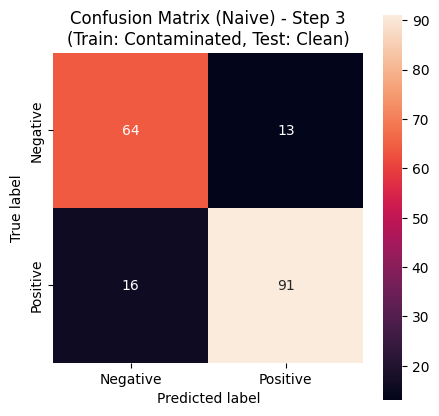

✅ Step 3 completed


===== Training Neural Network (Naive) at Step 4 =====
Misure di performance globali neural network naive

Accuracy: 0.8315217391304348
Precision: 0.8275862068965517
Recall: 0.897196261682243
F1-score: 0.8609865470852018
Step 4 - Neural Network (Naive)
  Accuracy Test:   0.8315
  Accuracy Train:  0.8683
  Precision:       0.8276
  Recall:          0.8972
  F1-score:        0.8610
  Training time:   0.1752 sec


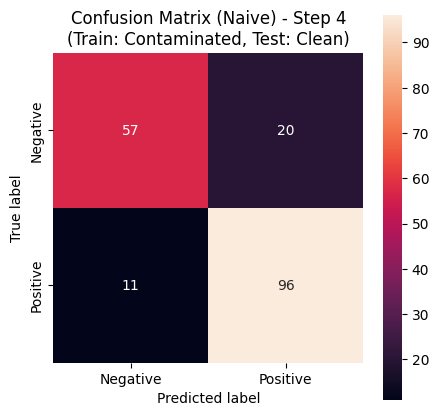

✅ Step 4 completed


===== Training Neural Network (Naive) at Step 5 =====
Misure di performance globali neural network naive

Accuracy: 0.842391304347826
Precision: 0.8679245283018868
Recall: 0.8598130841121495
F1-score: 0.863849765258216
Step 5 - Neural Network (Naive)
  Accuracy Test:   0.8424
  Accuracy Train:  0.8731
  Precision:       0.8679
  Recall:          0.8598
  F1-score:        0.8638
  Training time:   0.4000 sec


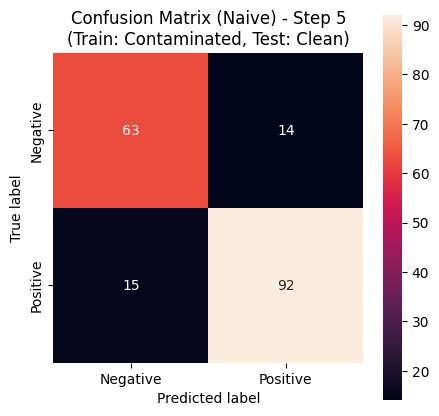

✅ Step 5 completed


===== Training Neural Network (Naive) at Step 6 =====
Misure di performance globali neural network naive

Accuracy: 0.8206521739130435
Precision: 0.8775510204081632
Recall: 0.8037383177570093
F1-score: 0.8390243902439024
Step 6 - Neural Network (Naive)
  Accuracy Test:   0.8207
  Accuracy Train:  0.8670
  Precision:       0.8776
  Recall:          0.8037
  F1-score:        0.8390
  Training time:   0.2778 sec


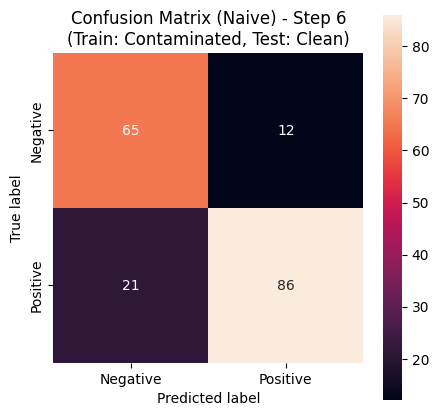

✅ Step 6 completed


===== Training Neural Network (Naive) at Step 7 =====
Misure di performance globali neural network naive

Accuracy: 0.8369565217391305
Precision: 0.8468468468468469
Recall: 0.8785046728971962
F1-score: 0.8623853211009175
Step 7 - Neural Network (Naive)
  Accuracy Test:   0.8370
  Accuracy Train:  0.8819
  Precision:       0.8468
  Recall:          0.8785
  F1-score:        0.8624
  Training time:   0.4277 sec


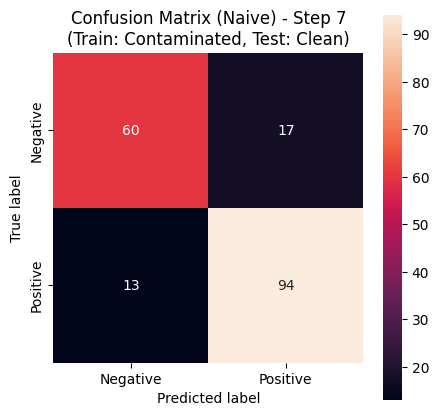

✅ Step 7 completed


===== Training Neural Network (Naive) at Step 8 =====
Misure di performance globali neural network naive

Accuracy: 0.8043478260869565
Precision: 0.865979381443299
Recall: 0.7850467289719626
F1-score: 0.8235294117647058
Step 8 - Neural Network (Naive)
  Accuracy Test:   0.8043
  Accuracy Train:  0.8509
  Precision:       0.8660
  Recall:          0.7850
  F1-score:        0.8235
  Training time:   0.2979 sec


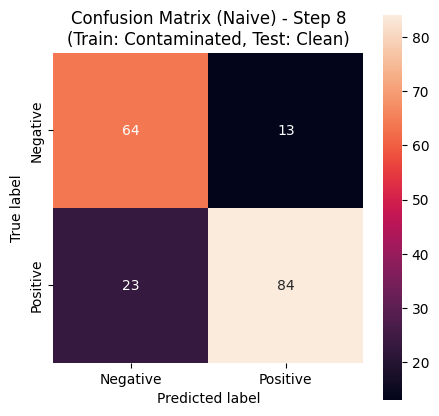

✅ Step 8 completed


===== Training Neural Network (Naive) at Step 9 =====
Misure di performance globali neural network naive

Accuracy: 0.8478260869565217
Precision: 0.8319327731092437
Recall: 0.9252336448598131
F1-score: 0.8761061946902655
Step 9 - Neural Network (Naive)
  Accuracy Test:   0.8478
  Accuracy Train:  0.8685
  Precision:       0.8319
  Recall:          0.9252
  F1-score:        0.8761
  Training time:   0.2515 sec


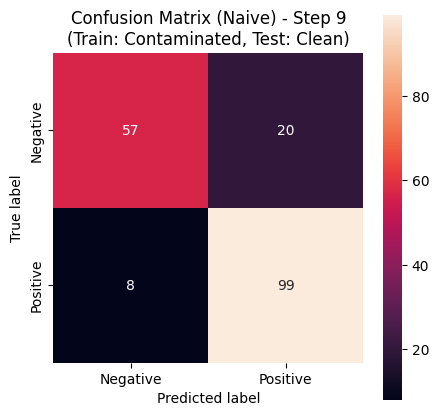

✅ Step 9 completed


===== Training Neural Network (Optimized) at Step 0 =====
Misure di performance globali neural network optimized

Accuracy: 0.8043478260869565
Precision: 0.865979381443299
Recall: 0.7850467289719626
F1-score: 0.8235294117647058
Step 0 - Neural Network (Optimized)
  Accuracy Test:   0.8043
  Accuracy Train:  0.8488
  Precision:       0.8660
  Recall:          0.7850
  F1-score:        0.8235
  Training time:   0.1342 sec


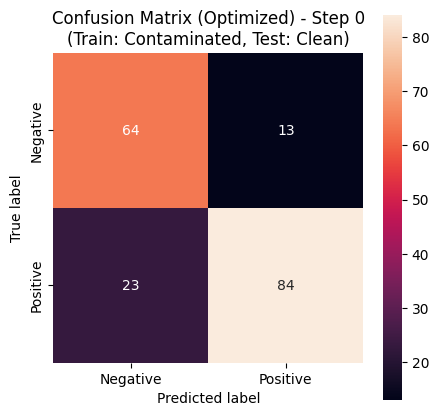

✅ Step 0 completed


===== Training Neural Network (Optimized) at Step 1 =====
Misure di performance globali neural network optimized

Accuracy: 0.8369565217391305
Precision: 0.8130081300813008
Recall: 0.9345794392523364
F1-score: 0.8695652173913043
Step 1 - Neural Network (Optimized)
  Accuracy Test:   0.8370
  Accuracy Train:  0.8636
  Precision:       0.8130
  Recall:          0.9346
  F1-score:        0.8696
  Training time:   0.1493 sec


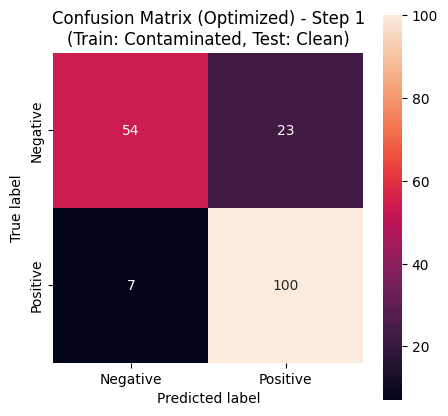

✅ Step 1 completed


===== Training Neural Network (Optimized) at Step 2 =====
Misure di performance globali neural network optimized

Accuracy: 0.842391304347826
Precision: 0.8305084745762712
Recall: 0.9158878504672897
F1-score: 0.8711111111111111
Step 2 - Neural Network (Optimized)
  Accuracy Test:   0.8424
  Accuracy Train:  0.8658
  Precision:       0.8305
  Recall:          0.9159
  F1-score:        0.8711
  Training time:   0.2171 sec


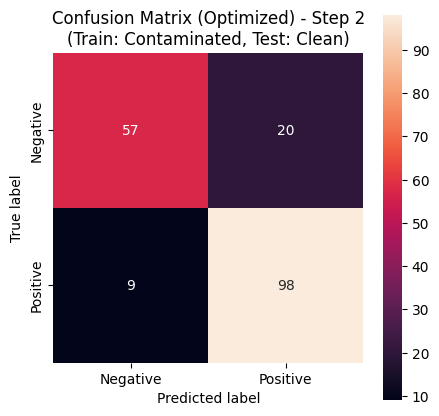

✅ Step 2 completed


===== Training Neural Network (Optimized) at Step 3 =====
Misure di performance globali neural network optimized

Accuracy: 0.842391304347826
Precision: 0.875
Recall: 0.8504672897196262
F1-score: 0.8625592417061612
Step 3 - Neural Network (Optimized)
  Accuracy Test:   0.8424
  Accuracy Train:  0.8531
  Precision:       0.8750
  Recall:          0.8505
  F1-score:        0.8626
  Training time:   0.1463 sec


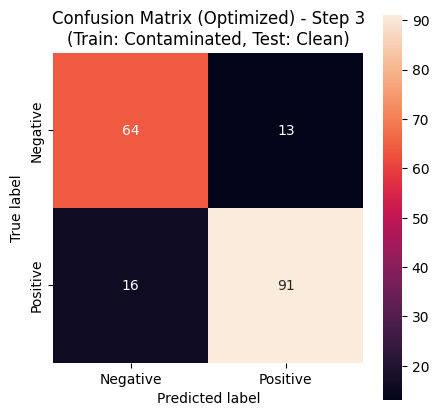

✅ Step 3 completed


===== Training Neural Network (Optimized) at Step 4 =====
Misure di performance globali neural network optimized

Accuracy: 0.8315217391304348
Precision: 0.8275862068965517
Recall: 0.897196261682243
F1-score: 0.8609865470852018
Step 4 - Neural Network (Optimized)
  Accuracy Test:   0.8315
  Accuracy Train:  0.8683
  Precision:       0.8276
  Recall:          0.8972
  F1-score:        0.8610
  Training time:   0.2786 sec


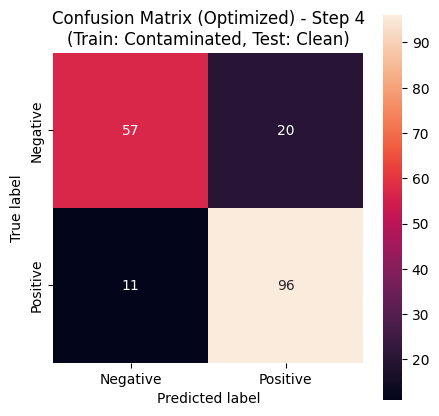

✅ Step 4 completed


===== Training Neural Network (Optimized) at Step 5 =====
Misure di performance globali neural network optimized

Accuracy: 0.842391304347826
Precision: 0.8679245283018868
Recall: 0.8598130841121495
F1-score: 0.863849765258216
Step 5 - Neural Network (Optimized)
  Accuracy Test:   0.8424
  Accuracy Train:  0.8731
  Precision:       0.8679
  Recall:          0.8598
  F1-score:        0.8638
  Training time:   0.3674 sec


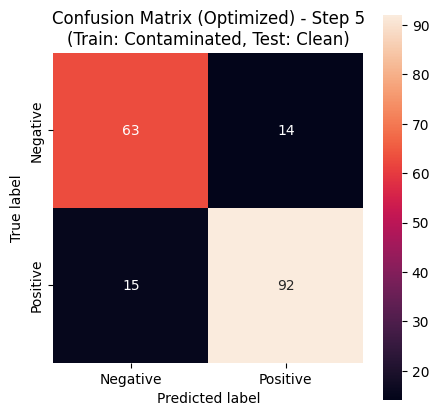

✅ Step 5 completed


===== Training Neural Network (Optimized) at Step 6 =====
Misure di performance globali neural network optimized

Accuracy: 0.8206521739130435
Precision: 0.8775510204081632
Recall: 0.8037383177570093
F1-score: 0.8390243902439024
Step 6 - Neural Network (Optimized)
  Accuracy Test:   0.8207
  Accuracy Train:  0.8670
  Precision:       0.8776
  Recall:          0.8037
  F1-score:        0.8390
  Training time:   0.2919 sec


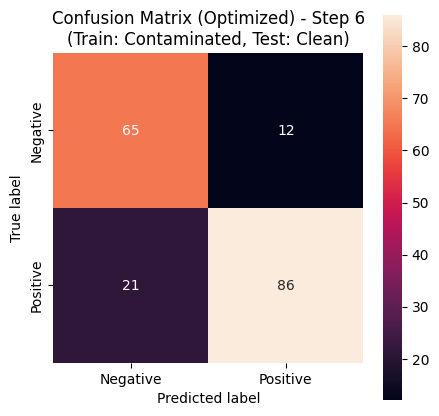

✅ Step 6 completed


===== Training Neural Network (Optimized) at Step 7 =====
Misure di performance globali neural network optimized

Accuracy: 0.8369565217391305
Precision: 0.8468468468468469
Recall: 0.8785046728971962
F1-score: 0.8623853211009175
Step 7 - Neural Network (Optimized)
  Accuracy Test:   0.8370
  Accuracy Train:  0.8819
  Precision:       0.8468
  Recall:          0.8785
  F1-score:        0.8624
  Training time:   0.2936 sec


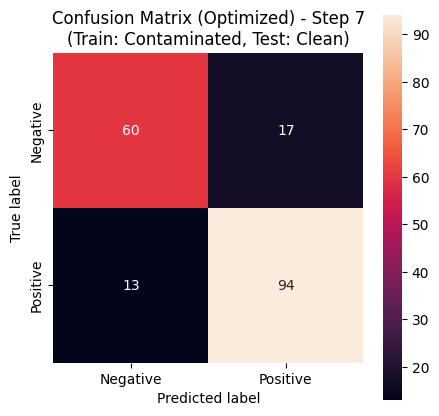

✅ Step 7 completed


===== Training Neural Network (Optimized) at Step 8 =====
Misure di performance globali neural network optimized

Accuracy: 0.8043478260869565
Precision: 0.865979381443299
Recall: 0.7850467289719626
F1-score: 0.8235294117647058
Step 8 - Neural Network (Optimized)
  Accuracy Test:   0.8043
  Accuracy Train:  0.8509
  Precision:       0.8660
  Recall:          0.7850
  F1-score:        0.8235
  Training time:   0.3126 sec


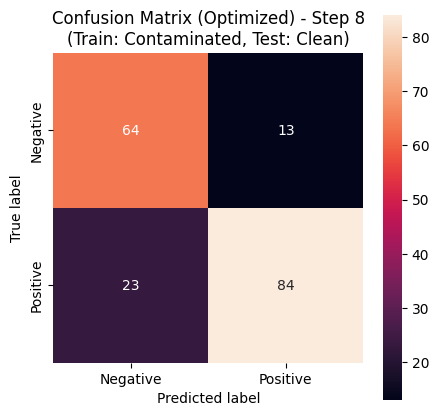

✅ Step 8 completed


===== Training Neural Network (Optimized) at Step 9 =====
Misure di performance globali neural network optimized

Accuracy: 0.8478260869565217
Precision: 0.8319327731092437
Recall: 0.9252336448598131
F1-score: 0.8761061946902655
Step 9 - Neural Network (Optimized)
  Accuracy Test:   0.8478
  Accuracy Train:  0.8685
  Precision:       0.8319
  Recall:          0.9252
  F1-score:        0.8761
  Training time:   0.2898 sec


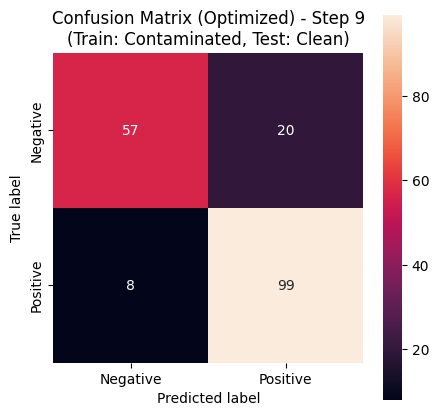

✅ Step 9 completed



In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
import time

feature_importances = {}

confusion_matrix_values = {}


# Carica i modelli ottimizzati (se già salvati)
best_dt_params = joblib.load('best_decision_tree_model.pkl')
best_svm_params = joblib.load('best_svm_model.pkl')
best_nn_params = joblib.load('best_nn_model.pkl')
best_nn_params = {
    'activation': best_nn_params.get('model__activation', 'relu'),
    'hidden_layer_sizes': best_nn_params.get('model__hidden_layer_sizes', (100,)),
    'random_state': 42,
    'max_iter': 1000
}

# Split del dataset originale per ottenere il test set pulito
X_original = df.drop('HeartDisease', axis=1)
y_original = df['HeartDisease']
X_temp, X_test_clean, y_temp, y_test_clean = train_test_split(
    X_original, y_original, test_size=0.2, random_state=0
)

def train_and_evaluate_duplicates(
    datasets, X_test_clean, y_test_clean, 
    model_class, model_params, model_name, 
    approach_name, timing_collector, all_metrics_list,
    continuous_features, binary_features,
    mutua_informazione_feature=None,
    feature_importances=None
):
    """
    Train and evaluate models on datasets with duplicated values.
    """
    cm_key = f"{model_name} - {approach_name}"
    if cm_key not in confusion_matrix_values:
        confusion_matrix_values[cm_key] = {}
    

    for step_idx, duplicated_df in enumerate(datasets):
        print(f"\n===== Training {model_name} ({approach_name}) at Step {step_idx} =====")
        
        # Split del dataset contaminato
        X_contaminated = duplicated_df.drop('HeartDisease', axis=1)
        y_contaminated = duplicated_df['HeartDisease']
        X_train, _, y_train, _ = train_test_split(
            X_contaminated, y_contaminated, test_size=0.2, random_state=0
        )
        
        # Dati processati (niente imputazione perché dataset duplicato)
        X_train_processed = X_train
        X_test_processed = X_test_clean
        y_test = y_test_clean
        
        # Mutual Information sul training set
        mi = mutual_info_classif(X_train_processed, y_train, discrete_features='auto', random_state=42)
        mi_df = pd.DataFrame({
            "feature": X_train.columns,
            "mutual_info": mi
        })
        mi_numerical = mi_df[mi_df["feature"].isin(continuous_features)]["mutual_info"].mean()
        mi_binary = mi_df[mi_df["feature"].isin(binary_features)]["mutual_info"].mean()
        
        if mutua_informazione_feature is not None:
            original_size = len(duplicated_df) / (1 + (step_idx + 1) / 10)  # Stima
            duplicate_percentage = ((len(duplicated_df) - original_size) / original_size) * 100
            
            mutua_informazione_feature.append({
                "MI_numerical": mi_numerical,
                "MI_binary": mi_binary,
                "perc_duplicates": f"{duplicate_percentage:.1f}%",
                "model": model_name,
                "approach": approach_name,
                "step": step_idx
            })
        
        # Training
        model = model_class(**model_params)
        start_time = time.time()
        model.fit(X_train_processed, y_train)
        end_time = time.time()
        training_time = end_time - start_time
        
        # Timing
        timing_key = f"{model_name.lower().replace(' ', '_')}_{approach_name.lower()}_duplicates_training_step_{step_idx}"
        timing_collector[timing_key] = training_time
        
        # Predizioni
        y_pred = model.predict(X_test_processed)
        y_pred_train = model.predict(X_train_processed)
        
        # Accuracy su training
        accuracy_train = accuracy_score(y_train, y_pred_train)
        
        # Calcolo metriche
        metrics = calculate_metrics(y_test, y_pred, model_name, approach_name, step_idx)
        metrics['training_time'] = training_time
        metrics['train_accuracy'] = accuracy_train
        metrics['contamination_step'] = step_idx
        metrics['test_set_type'] = 'clean'
        
        # Aggiunta alle metriche globali
        all_metrics_list.append(metrics)
        
        # Stampa metriche step per step
        print(f"Step {step_idx} - {model_name} ({approach_name})")
        print(f"  Accuracy Test:   {metrics['accuracy']:.4f}")
        print(f"  Accuracy Train:  {accuracy_train:.4f}")
        print(f"  Precision:       {metrics['precision']:.4f}")
        print(f"  Recall:          {metrics['recall']:.4f}")
        print(f"  F1-score:        {metrics['f1_score']:.4f}")
        print(f"  Training time:   {training_time:.4f} sec")
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        TN, FP, FN, TP = cm.ravel()
        # Salva i valori nella struttura dati
        confusion_matrix_values[cm_key][step_idx] = {
            'TN': int(TN),  # True Negative
            'FP': int(FP),  # False Positive  
            'FN': int(FN),  # False Negative
            'TP': int(TP),  # True Positive
            'confusion_matrix': cm.tolist()  # Salva anche la matrice completa
        }
        plt.figure(figsize=(5,5))
        sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        plt.title(f"Confusion Matrix ({approach_name}) - Step {step_idx}\n(Train: Contaminated, Test: Clean)")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

        # Feature importances (solo Decision Tree)
        key = f"{model_name} - {approach_name}"
        if model_name == 'Decision Tree':
            if key not in feature_importances:
                feature_importances[key] = {}
            feature_importances[key][step_idx] = model.feature_importances_
            print(f"Feature Importances: {model.feature_importances_}")
        
        print(f"✅ Step {step_idx} completed\n")

        if step_idx == 9 and model_name == 'Decision Tree':
            plt.figure(figsize=(20,10))
            plot_tree(model, filled=True)
            plt.title(f"Decision Tree ({approach_name}) addestrato su dataset con il {step_idx*10}% di duplicati")
            plt.show()

# Esegui i modelli su degraded_datasets
# Decision Tree - Naive
train_and_evaluate_duplicates(
    duplicated_dfs, X_test_clean, y_test_clean,
    DecisionTreeClassifier, {}, 'Decision Tree', 'Naive',
    timing_collector_duplicates, all_metrics_duplicates,
    continuous_features, binary_features,
    mutua_informazione_feature, feature_importances
)

# Decision Tree - Optimized  
train_and_evaluate_duplicates(
    duplicated_dfs, X_test_clean, y_test_clean,
    DecisionTreeClassifier, best_dt_params, 'Decision Tree', 'Optimized',
    timing_collector_duplicates, all_metrics_duplicates,
    continuous_features, binary_features,
    mutua_informazione_feature, feature_importances
)

# SVM - Naive
train_and_evaluate_duplicates(
    duplicated_dfs, X_test_clean, y_test_clean,
    SVC, {}, 'SVM', 'Naive',
    timing_collector_duplicates, all_metrics_duplicates,
    continuous_features, binary_features,
    mutua_informazione_feature, feature_importances
)

# SVM - Optimized
train_and_evaluate_duplicates(
    duplicated_dfs, X_test_clean, y_test_clean,
    SVC, best_svm_params, 'SVM', 'Optimized',
    timing_collector_duplicates, all_metrics_duplicates,
    continuous_features, binary_features,
    mutua_informazione_feature, feature_importances
)

# Neural Network - Naive
train_and_evaluate_duplicates(
    duplicated_dfs, X_test_clean, y_test_clean,
    MLPClassifier, {'random_state': 42, 'max_iter': 1000}, 'Neural Network', 'Naive',
    timing_collector_duplicates, all_metrics_duplicates,
    continuous_features, binary_features,
    mutua_informazione_feature, feature_importances
)

# Neural Network - Optimized
train_and_evaluate_duplicates(
    duplicated_dfs, X_test_clean, y_test_clean,
    MLPClassifier, best_nn_params, 'Neural Network', 'Optimized',
    timing_collector_duplicates, all_metrics_duplicates,
    continuous_features, binary_features,
    mutua_informazione_feature, feature_importances
)

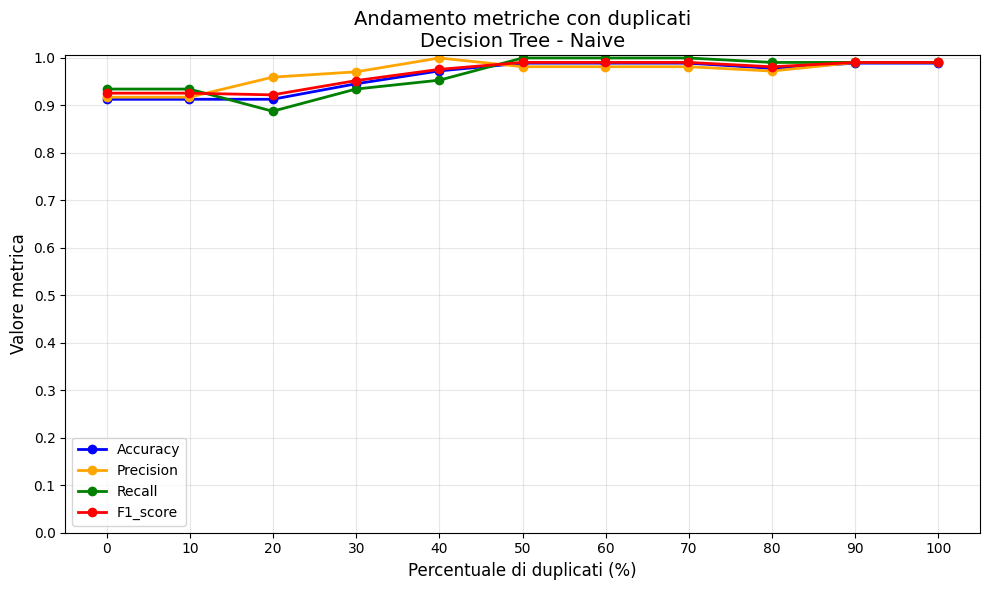

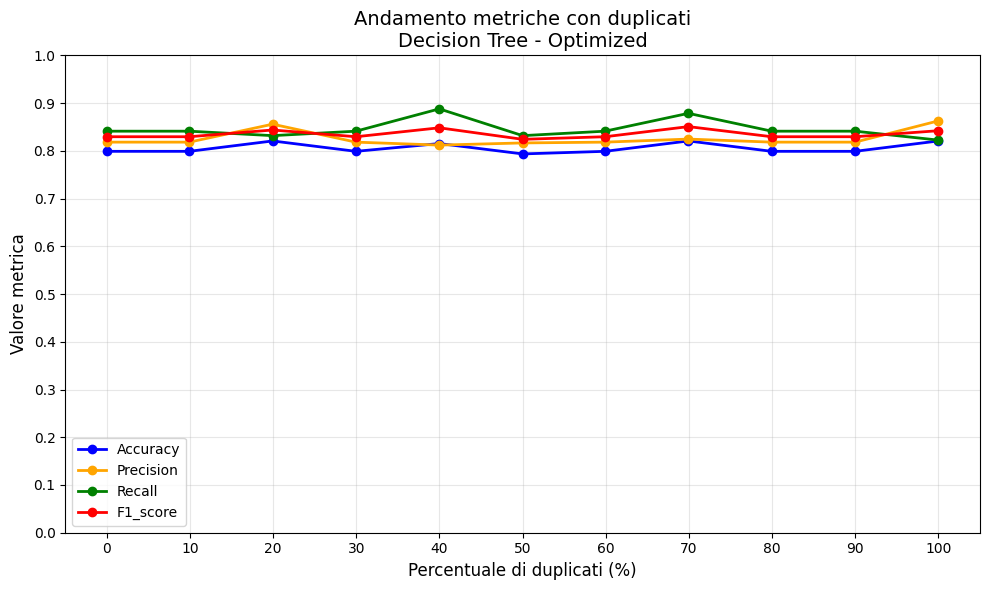

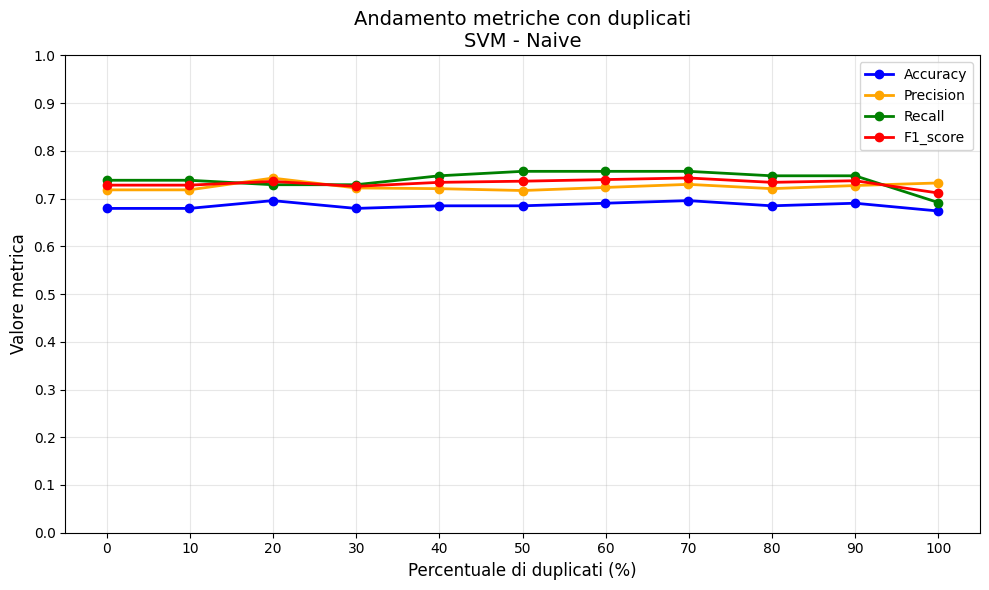

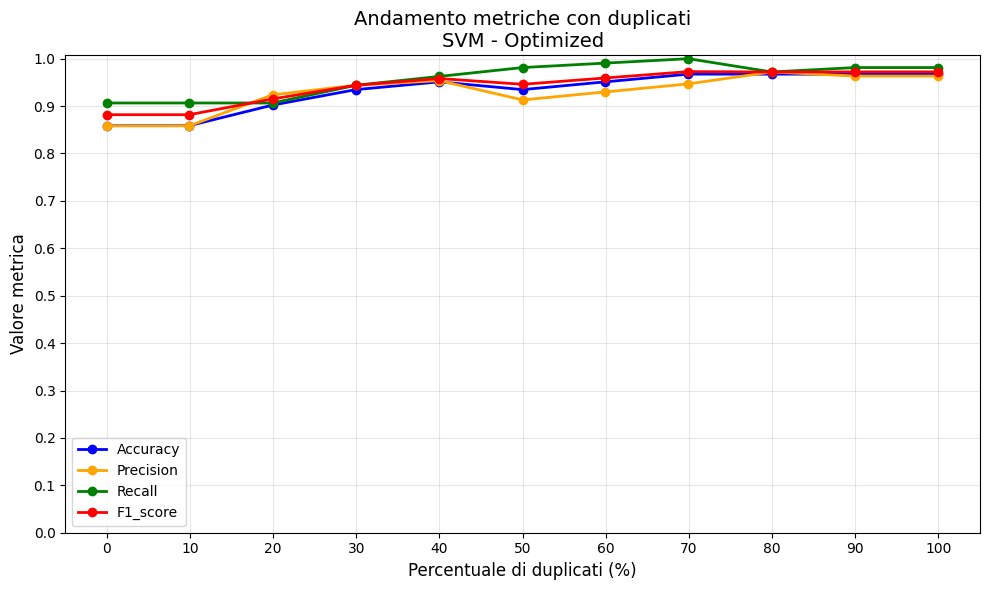

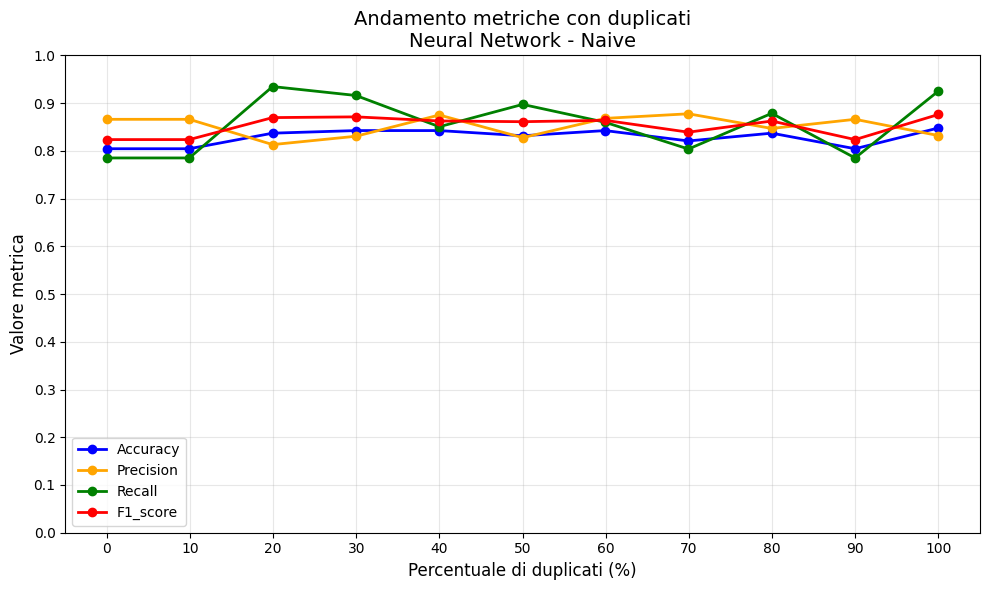

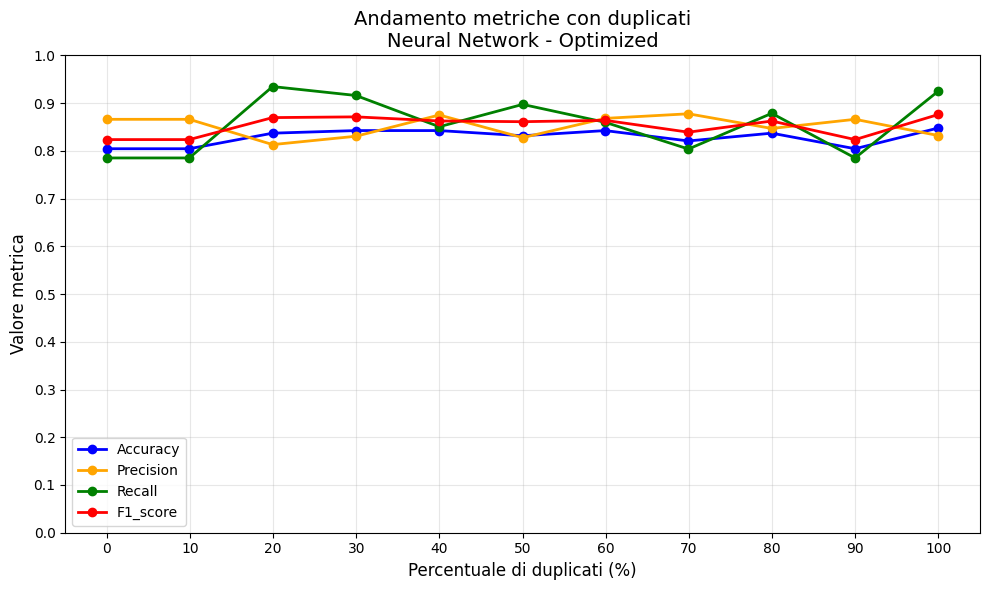

In [10]:
def plot_metrics_by_duplicates(all_metrics_duplicates, duplicated_datasets, original_df, model_name, approach='Optimized', figsize=(10, 6)):
    """
    Crea un grafico unico che mostra Accuracy, Precision, Recall e F1-score
    al crescere della percentuale di duplicati per un dato modello e approccio,
    includendo il dataset pulito (0% duplicati).
    
    Args:
        all_metrics_duplicates: lista di metriche calcolate sui dataset duplicati
        duplicated_datasets: lista di DataFrame con valori duplicati
        original_df: DataFrame originale pulito (senza duplicati)
        model_name: nome del modello da plottare
        approach: 'Naive' o 'Optimized'
        figsize: dimensione del grafico
    """
    # Dimensione dataset originale
    original_size = len(original_df)
    
    # Percentuale di duplicati rispetto al dataset originale
    duplicate_rates = [(len(df) - original_size) / original_size for df in duplicated_datasets]
    
    # Trasformo metriche in DataFrame
    metrics_df = pd.DataFrame(all_metrics_duplicates)
    metrics_df['duplicate_rate'] = [duplicate_rates[s] for s in metrics_df['contamination_step']]
    
    # Filtriamo per modello e approccio
    filtered_df = metrics_df[
        (metrics_df["approach"] == approach) & 
        (metrics_df["model"] == model_name)
    ].sort_values("duplicate_rate")
    
    if filtered_df.empty:
        print(f"Nessun dato trovato per {model_name} ({approach})")
        return
    
    # Aggiungo il caso iniziale (0% duplicati) se non presente
    if not (filtered_df['duplicate_rate'] == 0).any():
        clean_row = filtered_df.iloc[0].copy()
        clean_row['duplicate_rate'] = 0.0
        filtered_df = pd.concat([pd.DataFrame([clean_row]), filtered_df], ignore_index=True)
    
    # Metriche da plottare
    metric_names = ['accuracy', 'precision', 'recall', 'f1_score']
    colors = ['blue', 'orange', 'green', 'red']
    
    plt.figure(figsize=figsize)
    
    for metric, color in zip(metric_names, colors):
        plt.plot(filtered_df["duplicate_rate"]*100, filtered_df[metric],
                 marker='o', linewidth=2, markersize=6, color=color, label=metric.capitalize())

    plt.xlabel("Percentuale di duplicati (%)", fontsize=12)
    plt.ylabel("Valore metrica", fontsize=12)
    plt.title(f"Andamento metriche con duplicati\n{model_name} - {approach}", fontsize=14)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xticks(np.arange(0, 101, 10))
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()



plot_metrics_by_duplicates(all_metrics_duplicates, duplicated_dfs, df, 'Decision Tree', approach='Naive')
plot_metrics_by_duplicates(all_metrics_duplicates, duplicated_dfs, df, 'Decision Tree', approach='Optimized')
plot_metrics_by_duplicates(all_metrics_duplicates, duplicated_dfs, df, 'SVM', approach='Naive')
plot_metrics_by_duplicates(all_metrics_duplicates, duplicated_dfs, df, 'SVM', approach='Optimized')
plot_metrics_by_duplicates(all_metrics_duplicates, duplicated_dfs, df, 'Neural Network', approach='Naive')
plot_metrics_by_duplicates(all_metrics_duplicates, duplicated_dfs, df, 'Neural Network', approach='Optimized')


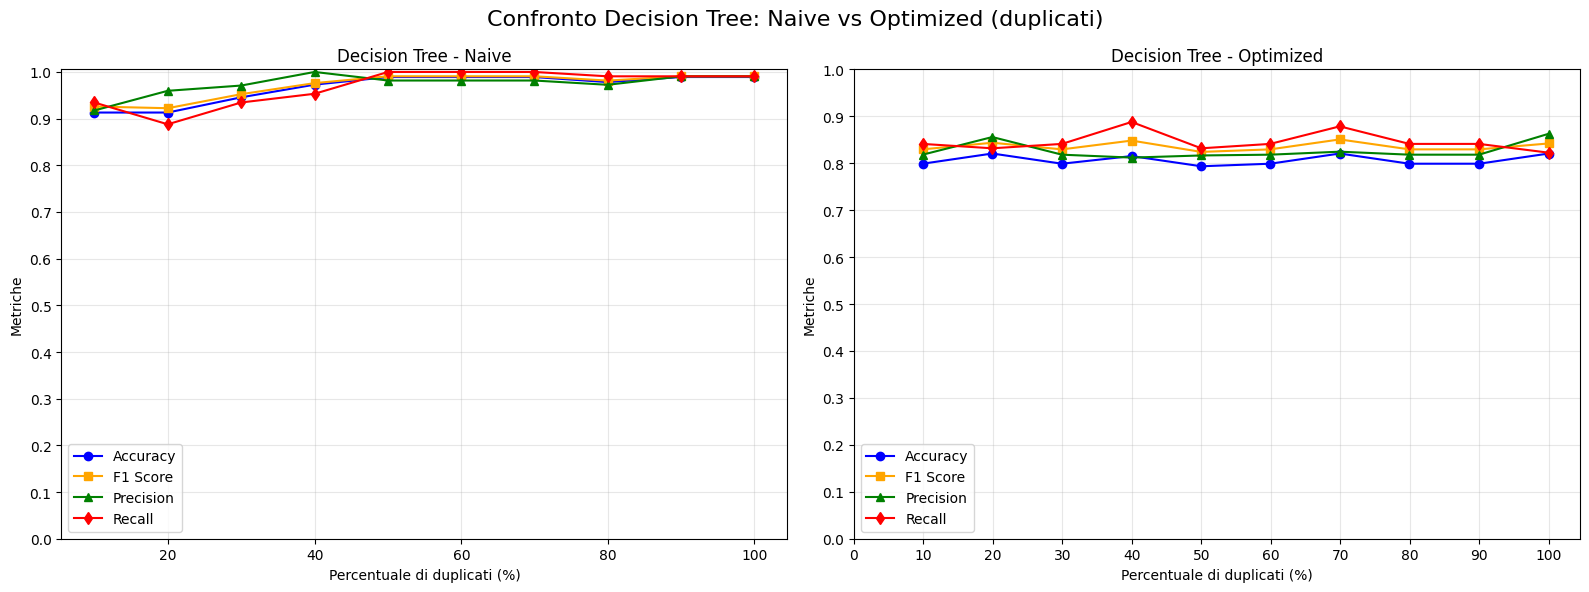

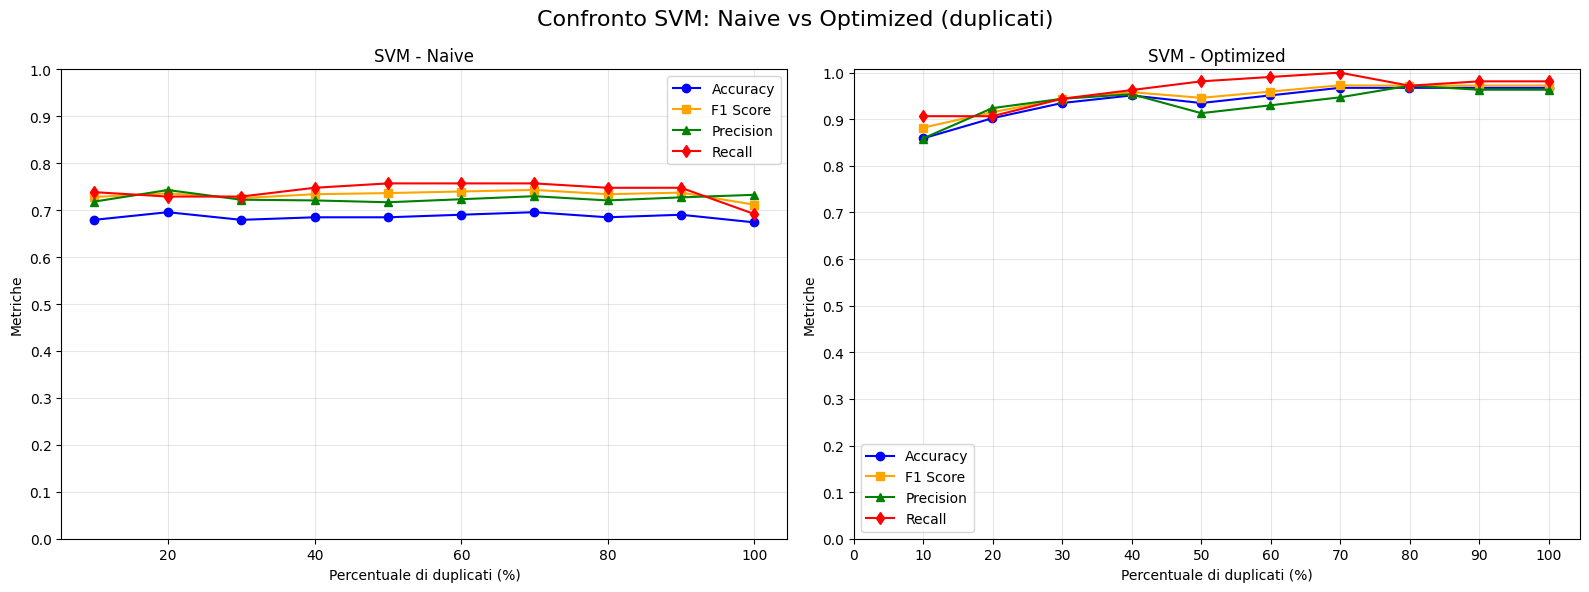

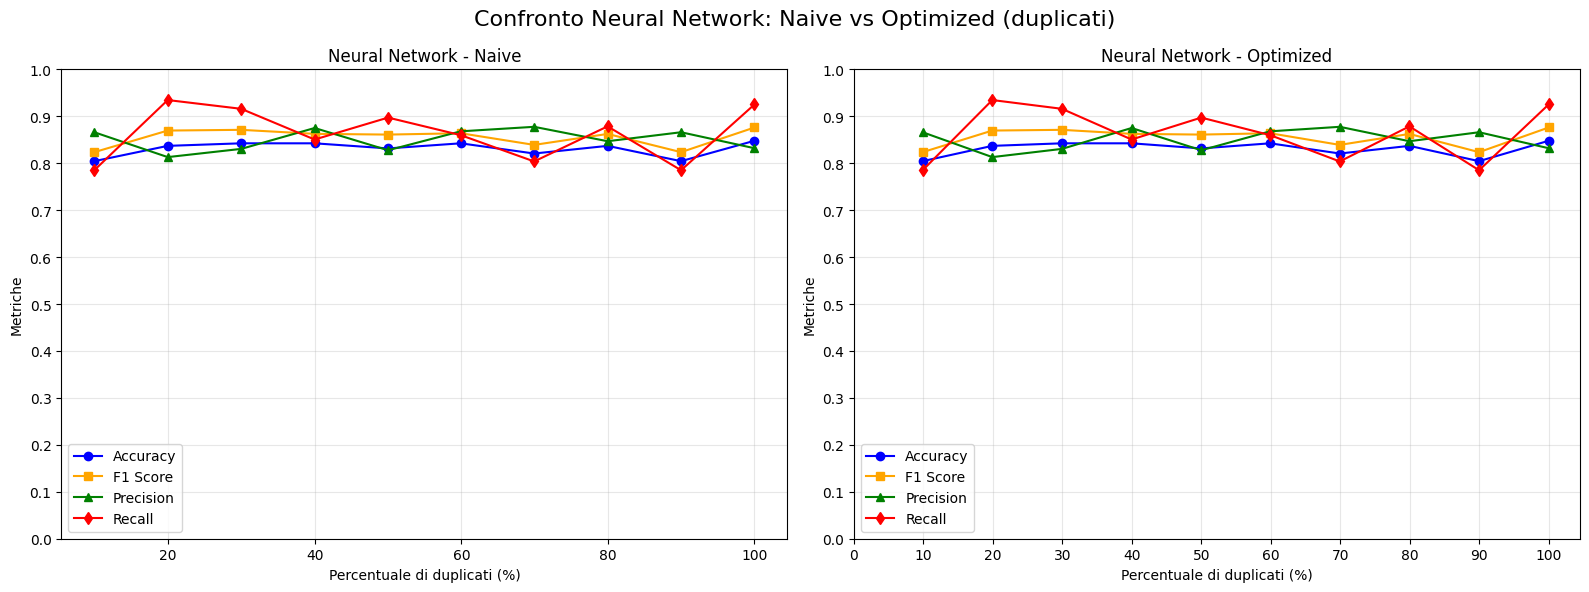

In [11]:
def plot_naive_vs_optimized_duplicates(model_name, duplicated_datasets, original_df):
    """
    Confronta approccio Naive vs Optimized per un modello con dataset contenenti duplicati.
    
    Args:
        model_name: nome del modello da plottare
        duplicated_datasets: lista di DataFrame con duplicati
        original_df: dataset originale pulito
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Dimensione dataset originale
    original_size = len(original_df)
    
    # Calcoliamo percentuale di duplicati rispetto al dataset originale
    duplicate_rates = [(len(df) - original_size) / original_size for df in duplicated_datasets]
    
    for i, approach in enumerate(['Naive', 'Optimized']):
        metrics_df = pd.DataFrame(all_metrics_duplicates)
        
        # Filtriamo per modello e approccio
        filtered_df = metrics_df[
            (metrics_df["approach"] == approach) &
            (metrics_df["model"] == model_name)
        ].sort_values("contamination_step")
        
        if filtered_df.empty:
            print(f"Nessun dato trovato per {model_name} ({approach})")
            continue
        
        # Aggiungiamo il caso pulito (0% duplicati) se non presente
        if not (filtered_df['contamination_step'] == 0).any():
            clean_row = filtered_df.iloc[0].copy()
            clean_row['contamination_step'] = 0
            filtered_df = pd.concat([pd.DataFrame([clean_row]), filtered_df], ignore_index=True)
        
        # Calcoliamo la percentuale di duplicati corrispondente a ciascuno step
        filtered_df['duplicate_rate'] = [duplicate_rates[s] for s in filtered_df['contamination_step']]
        
        # Plot metriche
        axes[i].plot(filtered_df["duplicate_rate"]*100, filtered_df["accuracy"], 
                     marker='o', color='blue', label="Accuracy")
        axes[i].plot(filtered_df["duplicate_rate"]*100, filtered_df["f1_score"], 
                     marker='s', color='orange', label="F1 Score")
        axes[i].plot(filtered_df["duplicate_rate"]*100, filtered_df["precision"], 
                     marker='^', color='green', label="Precision")
        axes[i].plot(filtered_df["duplicate_rate"]*100, filtered_df["recall"], 
                     marker='d', color='red', label="Recall")
        
        axes[i].set_xlabel("Percentuale di duplicati (%)")
        axes[i].set_ylabel("Metriche")
        axes[i].set_title(f"{model_name} - {approach}")
        axes[i].set_yticks(np.arange(0, 1.1, 0.1))
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    plt.suptitle(f"Confronto {model_name}: Naive vs Optimized (duplicati)", fontsize=16)
    plt.xticks(np.arange(0, 101, 10))
    plt.tight_layout()
    plt.show()


plot_naive_vs_optimized_duplicates('Decision Tree', duplicated_dfs, df)
plot_naive_vs_optimized_duplicates('SVM', duplicated_dfs, df)
plot_naive_vs_optimized_duplicates('Neural Network', duplicated_dfs, df)


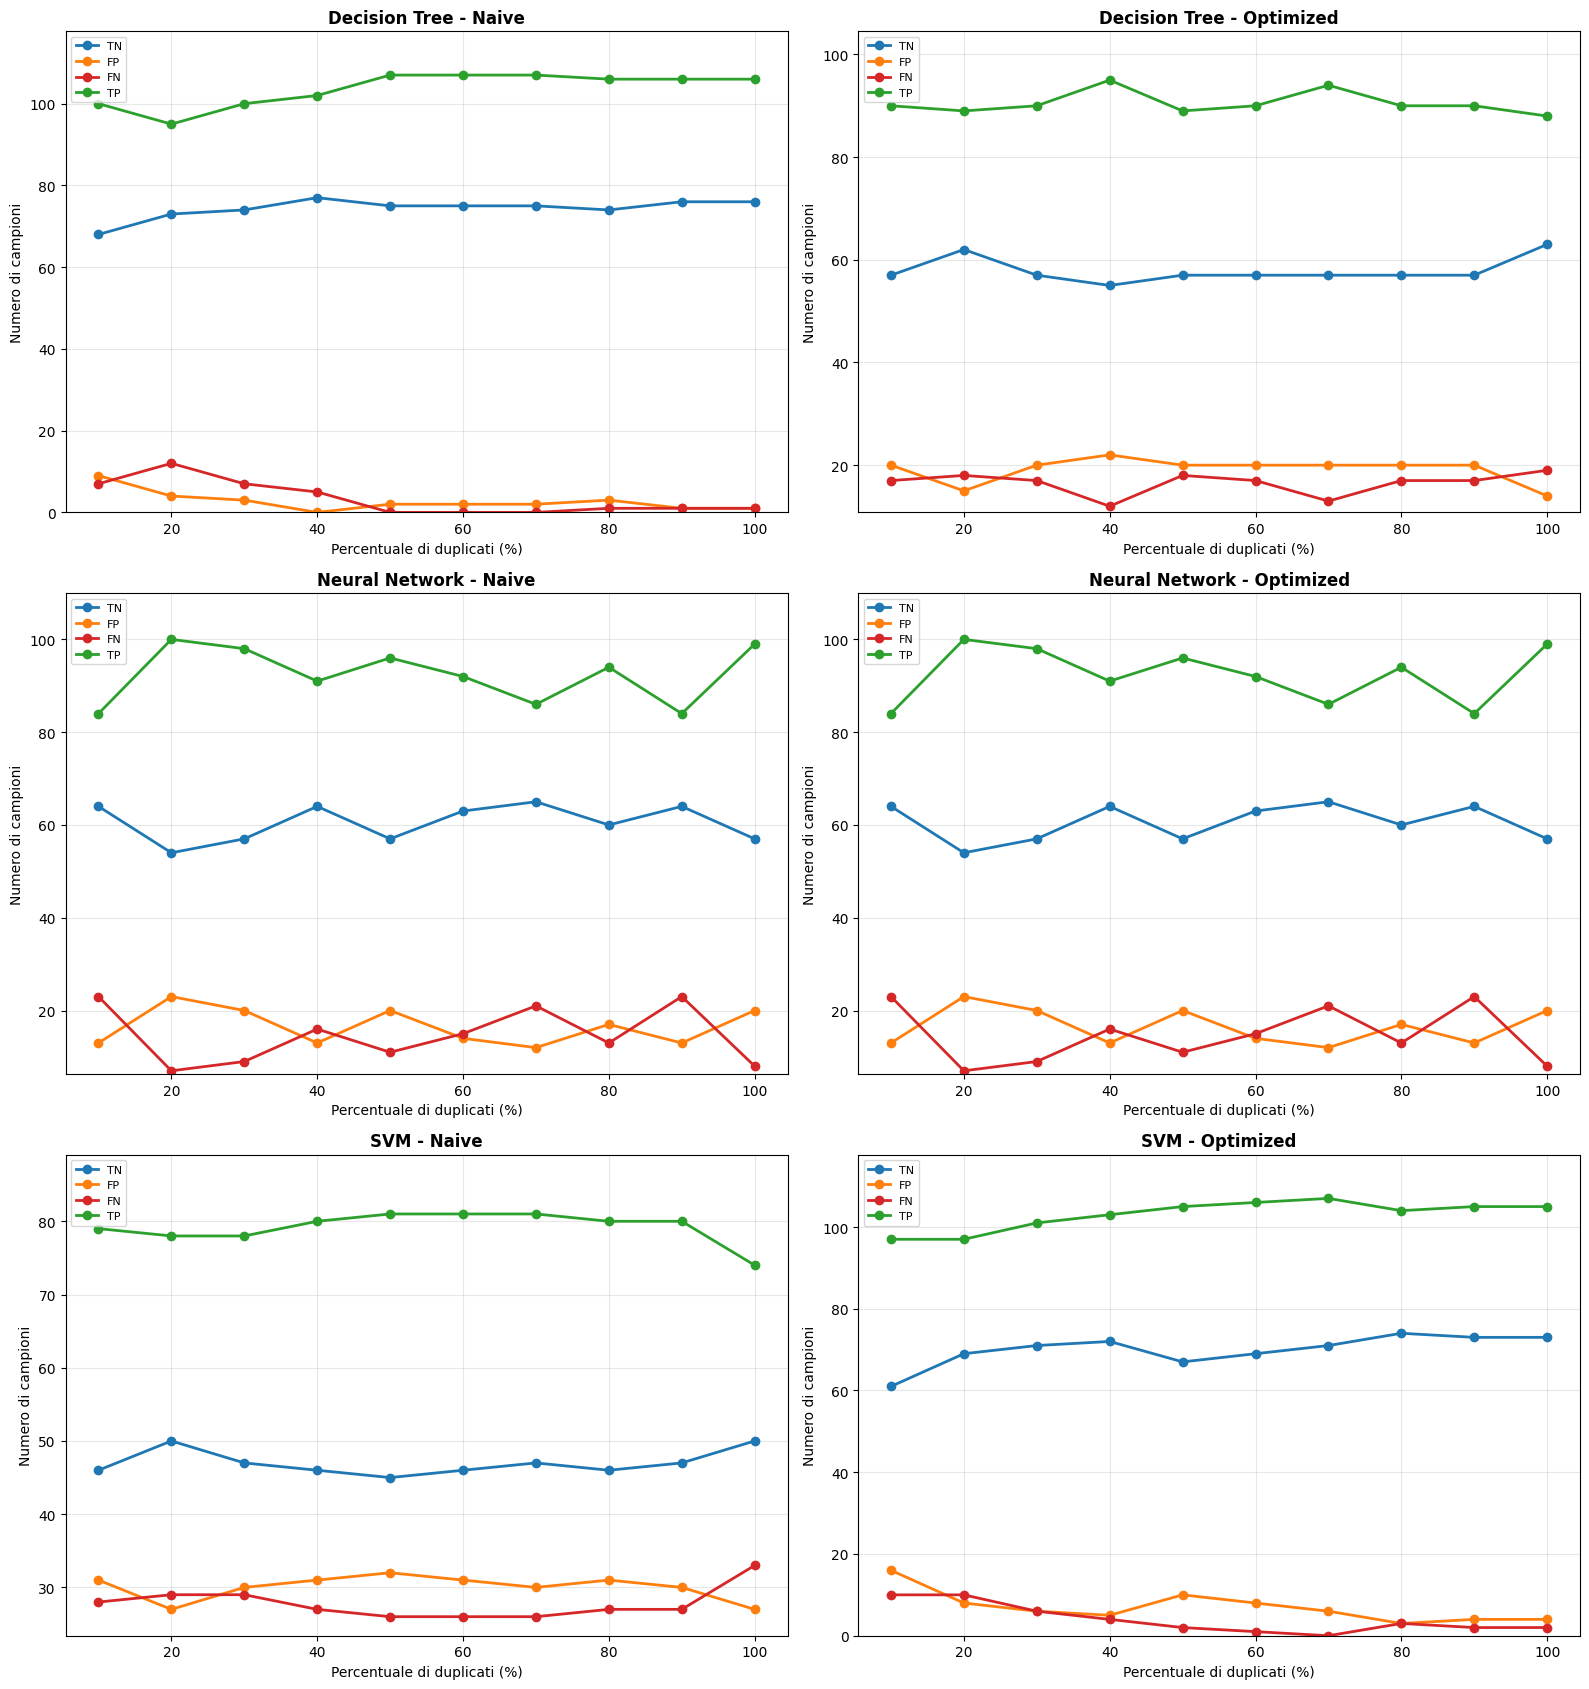

In [12]:
def plot_confusion_matrix_grid(confusion_matrix_values, duplicated_dfs=None):
    """
    Crea una griglia di grafici 2 colonne x N righe (Naive | Optimized per modello)
    
    Parameters:
    -----------
    confusion_matrix_values : dict
        Dizionario con i valori delle confusion matrix
    contamination_history : list, optional
        Storia della contaminazione con step e actual_rate (default: usa step numerici)
    """
    
    # Estrai tutti i modelli unici (DT, SVM, NN)
    models = sorted(set(key.split(' - ')[0] for key in confusion_matrix_values.keys()))
    
    # Setup subplot: 2 colonne (Naive, Optimized), righe = numero modelli
    fig, axes = plt.subplots(len(models), 2, figsize=(16, 17))
    
    # Se c'è solo un modello, axes diventa 1D → forzo 2D
    if len(models) == 1:
        axes = [axes]
    
    colors = {
        'TN': '#1f77b4',  # blu
        'FP': '#ff7f0e',  # arancione  
        'FN': '#d62728',  # rosso
        'TP': '#2ca02c'   # verde
    }
    
    for model_idx, model in enumerate(models):
        for col_idx, approach in enumerate(["Naive", "Optimized"]):
            ax = axes[model_idx][col_idx]
            
            # Trova la chiave corretta (es: "Decision Tree - Naive")
            model_key = f"{model} - {approach}"
            if model_key not in confusion_matrix_values:
                continue
            
            # Estrai gli step
            steps = sorted(confusion_matrix_values[model_key].keys())
            
            nsteps = len(duplicated_dfs) if duplicated_dfs is not None else (max(steps) + 1)
            x_values = [((s+1) / nsteps) * 100 for s in steps]
            x_label = "Percentuale di duplicati (%)"
            
            # Estrai valori TN, FP, FN, TP
            metrics_data = {
                'TN': [confusion_matrix_values[model_key][step]['TN'] for step in steps],
                'FP': [confusion_matrix_values[model_key][step]['FP'] for step in steps],
                'FN': [confusion_matrix_values[model_key][step]['FN'] for step in steps],
                'TP': [confusion_matrix_values[model_key][step]['TP'] for step in steps]
            }
            
            # Plot linee
            for metric in ['TN', 'FP', 'FN', 'TP']:
                ax.plot(x_values, metrics_data[metric], 
                        color=colors[metric], 
                        marker='o',
                        linestyle='-',
                        label=metric,
                        linewidth=2,
                        markersize=6)
            
            # Personalizza subplot
            ax.set_title(f"{model} - {approach}", fontsize=12, fontweight='bold')
            ax.set_xlabel(x_label, fontsize=10)
            ax.set_ylabel("Numero di campioni", fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8, loc='upper left')
            
            # Limiti Y dinamici
            all_values = [v for metric in metrics_data.values() for v in metric]
            ax.set_ylim(min(all_values) * 0.9, max(all_values) * 1.1)
    
    plt.tight_layout()
    plt.show()

# Usa la funzione corretta
plot_confusion_matrix_grid(confusion_matrix_values, duplicated_dfs)

=== ANALISI DELL'IMPATTO DELLE FEATURE ===



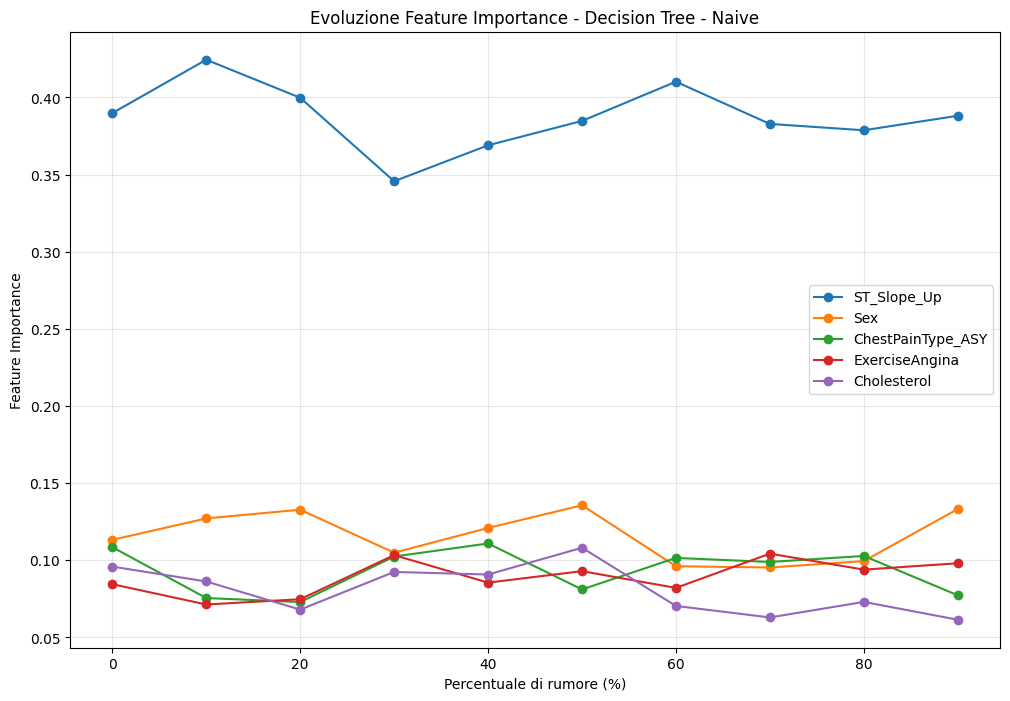


Decision Tree - Naive:
Media importanza feature continue: 0.0523
Media importanza feature binarie: 0.0568


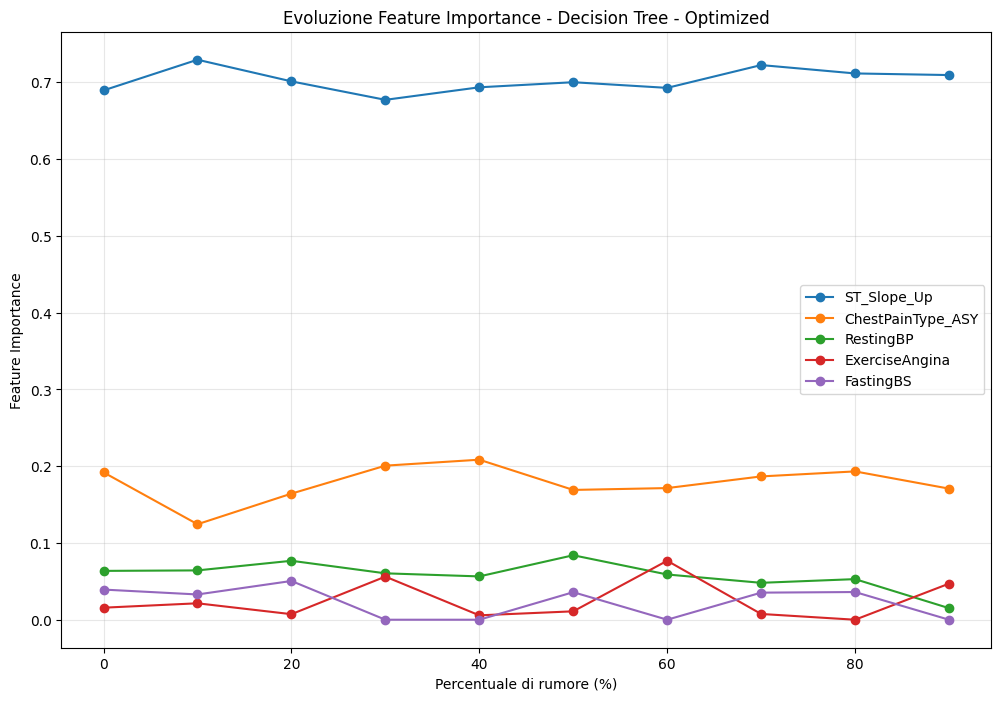


Decision Tree - Optimized:
Media importanza feature continue: 0.0132
Media importanza feature binarie: 0.0718


In [17]:
# %%
# ANALISI AGGIUNTIVE PER IL PROGETTO MISSING VALUES

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

'''
# %%
# 4. ANALISI ROC E CALIBRAZIONE
def roc_calibration_analysis(all_metrics_duplicates, duplicated_dfs, X_test_clean, y_test_clean):
    """
    Analisi delle curve ROC e della calibrazione dei modelli
    """
    print("=== ANALISI ROC E CALIBRAZIONE ===\n")
    
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.svm import SVC
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.impute import SimpleImputer
    from sklearn.calibration import CalibratedClassifierCV
    
    # Testa su alcuni step rappresentativi
    test_steps = [0.1, 0.3, 0.5]
    models_config = {
        'Decision Tree': DecisionTreeClassifier(),
        'SVM': SVC(probability=True),
        'Neural Network': MLPClassifier(max_iter=1000)
    }
    
    fig, axes = plt.subplots(len(test_steps), 3, figsize=(18, 6*len(test_steps)))
    if len(test_steps) == 1:
        axes = axes.reshape(1, -1)
    
    roc_results = []
    
    for step_idx, perc in enumerate(test_steps):
        if perc not in duplicated_dfs:
            continue

        df_degraded = duplicated_dfs[perc]
        X_contaminated = df_degraded.drop('HeartDisease', axis=1)
        y_contaminated = df_degraded['HeartDisease']
        
        X_train, _, y_train, _ = train_test_split(
            X_contaminated, y_contaminated, test_size=0.2, random_state=42
        )
        
        imputer = SimpleImputer(strategy='mean')
        X_train_imp = imputer.fit_transform(X_train)
        X_test_imp = imputer.transform(X_test_clean)
        
        for model_idx, (model_name, model) in enumerate(models_config.items()):
            model.fit(X_train_imp, y_train)
            
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test_imp)[:, 1]
            else:
                y_proba = model.decision_function(X_test_imp)
            
            # ROC Curve
            fpr, tpr, _ = roc_curve(y_test_clean, y_proba)
            auc_score = roc_auc_score(y_test_clean, y_proba)
            
            axes[step_idx, model_idx].plot(fpr, tpr, label=f'ROC (AUC={auc_score:.3f})')
            axes[step_idx, model_idx].plot([0, 1], [0, 1], 'k--', alpha=0.5)
            axes[step_idx, model_idx].set_xlabel('False Positive Rate')
            axes[step_idx, model_idx].set_ylabel('True Positive Rate')
            axes[step_idx, model_idx].set_title(f'{model_name} - {int(perc*100)}% Missing')
            axes[step_idx, model_idx].legend()
            axes[step_idx, model_idx].grid(True, alpha=0.3)
            
            roc_results.append({
                'model': model_name,
                'missing_perc': perc,
                'auc_score': auc_score
            })
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(roc_results)

'''

# %%
# 5. ANALISI DELL'IMPATTO SPECIFICO DELLE FEATURE
def feature_impact_analysis(feature_importances, continuous_features, binary_features):
    """
    Analizza come l'importanza delle feature cambia con l'aumento dei missing values
    """

    # Rimuovi la target dalle liste se presente
    continuous_features = [f for f in continuous_features if f != 'HeartDisease']
    binary_features = [f for f in binary_features if f != 'HeartDisease']

    print("=== ANALISI DELL'IMPATTO DELLE FEATURE ===\n")
    
    if not feature_importances:
        print("Nessuna feature importance disponibile")
        return
    
    # Solo per Decision Tree che ha feature_importances
    for model_approach, step_importances in feature_importances.items():
        if 'Decision Tree' not in model_approach:
            continue
            
        # Crea DataFrame delle importanze per step
        importance_data = []
        for step, importances in step_importances.items():
            # Verifica che importances sia un array/lista valida
            if importances is not None and len(importances) > 0:
                for feat_idx, importance in enumerate(importances):
                    importance_data.append({
                        'step': step,
                        'feature_idx': feat_idx,
                        'importance': importance
                    })
        
        if not importance_data:
            continue
            
        importance_df = pd.DataFrame(importance_data)
        
        # Visualizza l'evoluzione delle top 5 feature più importanti
        plt.figure(figsize=(12, 8))
        
        # Trova le top feature basate sull'importanza media
        avg_importance = importance_df.groupby('feature_idx')['importance'].mean().sort_values(ascending=False)
        top_features = avg_importance.head(5).index
        
        for feat_idx in top_features:
            feat_data = importance_df[importance_df['feature_idx'] == feat_idx].sort_values('step')
            # Ottieni il nome della feature corrispondente all'indice
            if feat_idx < len(continuous_features):
                feat_name = continuous_features[feat_idx]
            elif feat_idx < len(continuous_features) + len(binary_features):
                feat_name = binary_features[feat_idx - len(continuous_features)]
            else:
                feat_name = f"Feature {feat_idx}"
            plt.plot(feat_data['step']*10, feat_data['importance'], 
                    marker='o', label=feat_name)

        plt.xlabel('Percentuale di rumore (%)')
        plt.ylabel('Feature Importance')
        plt.title(f'Evoluzione Feature Importance - {model_approach}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Analisi separata per feature continue vs binarie (se hai i nomi delle feature)
        print(f"\n{model_approach}:")
        
        # Verifica che gli indici esistano prima di accedervi
        continuous_indices = [i for i in range(len(continuous_features)) if i in avg_importance.index]
        binary_start = len(continuous_features)
        binary_end = len(continuous_features) + len(binary_features)
        binary_indices = [i for i in range(binary_start, binary_end) if i in avg_importance.index]
        
        if continuous_indices:
            print(f"Media importanza feature continue: {avg_importance[continuous_indices].mean():.4f}")
        else:
            print("Nessuna feature continua trovata negli indici")
            
        if binary_indices:
            print(f"Media importanza feature binarie: {avg_importance[binary_indices].mean():.4f}")
        else:
            print("Nessuna feature binaria trovata negli indici")


# Esegui l'analisi comprehensive:
comprehensive_results = feature_impact_analysis(
    feature_importances, continuous_features, binary_features
)

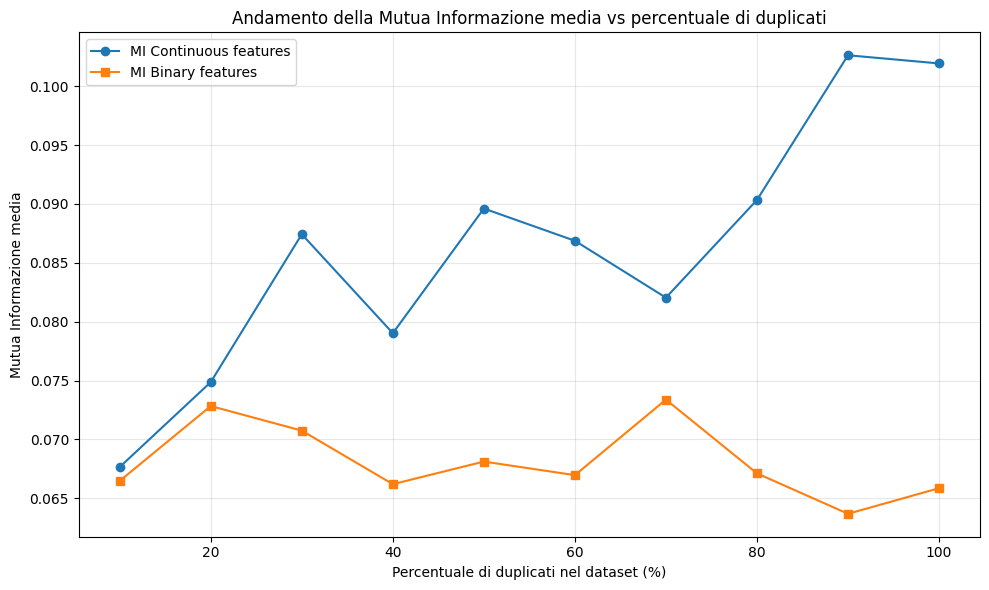

In [16]:
# Trasformiamo mutua_informazione_feature in DataFrame
df_results = pd.DataFrame(mutua_informazione_feature)

# Convertiamo la percentuale da stringa a float
df_results["perc_duplicates"] = df_results["perc_duplicates"].str.rstrip('%').astype(float)

# Raggruppiamo per percentuale di duplicati e calcoliamo la media
df_grouped = df_results.groupby("perc_duplicates")[["MI_numerical", "MI_binary"]].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_grouped["perc_duplicates"], df_grouped["MI_numerical"], marker='o', label="MI Continuous features")
plt.plot(df_grouped["perc_duplicates"], df_grouped["MI_binary"], marker='s', label="MI Binary features")

plt.xlabel("Percentuale di duplicati nel dataset (%)")
plt.ylabel("Mutua Informazione media")
plt.title("Andamento della Mutua Informazione media vs percentuale di duplicati")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
